- mean_test_auc_roc using Logistic Regression:
- mean_test_auc_roc using KNN:0.631033
- mean_test_auc_roc using SVM:0.658805
- mean_test_auc_roc using Random Forest:0.657398
- mean_test_auc_roc using Decision Tree:0.640888
- mean_test_auc_roc using **Naive Bayes:0.659468**
- mean_test_auc_roc using Neural Network(Adam):0.634302
- mean_test_auc_roc using Neural Network(SGD):0.630862
- mean_test_auc_roc using Neural Network(RMSprop):0.629448

In [1]:
# globally useful imports of standard libraries needed in this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from datetime import datetime

# specific libraries or classes needed for the work in this notebook
#from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LogisticRegressionCV
#from sklearn.svm import SVC
#from sklearn.naive_bayes import GaussianNB
#from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFpr, f_regression, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.pipeline import Pipeline
# need to use Pipeline from imblearn to add in a downsample or upsample
# to cross validation training
from imblearn.pipeline import Pipeline

# import project specific modules used in this notebook
import sys
sys.path.append('../src')
import mindwandering.data
import mindwandering.features
import mindwandering.evaluate
from mindwandering.data import FeatureScalerTransformer
from mindwandering.data import WinsorizationOutlierTransformer
from mindwandering.data import VIFThresholdTransformer
from mindwandering.data import FeatureSelectionTransformer
from mindwandering.data import ClassImbalanceTransformer
from mindwandering.data import GridSearchProgressHack


from sklearn.preprocessing import StandardScaler

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Input, Dense, Activation, Dropout, BatchNormalization,Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
from tensorflow.keras.layers import Conv1D,GRU,TimeDistributed,MaxPooling1D,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import AveragePooling1D,ZeroPadding1D

In [3]:
# Load Data and Features
df_features = mindwandering.data.get_df_features()
mind_wandered_label = mindwandering.data.get_mind_wandered_label()
participant_ids = mindwandering.data.get_participant_ids()

# Standard Scaling

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_features=scaler.fit_transform(df_features)

# Select k-best features

In [5]:
#from sklearn.feature_selection import SelectKBest,f_classif
#k=[12,15,18,21,24,31]
df_features = SelectKBest(f_classif,k=12).fit_transform(df_features,mind_wandered_label)

In [6]:
#participant_ids=participant_ids[:2193]

In [7]:
#participant_ids=participant_ids[:3300]

# Allknn undersampling

In [8]:
from imblearn.under_sampling import AllKNN
allknn = AllKNN()
df_features, mind_wandered_label = allknn.fit_resample(df_features, mind_wandered_label)

# SMOTEENN Oversampling

In [9]:
"""from imblearn.combine import SMOTEENN
sme = SMOTEENN(random_state=42)
df_features, mind_wandered_label = sme.fit_resample(df_features, mind_wandered_label)"""

'from imblearn.combine import SMOTEENN\nsme = SMOTEENN(random_state=42)\ndf_features, mind_wandered_label = sme.fit_resample(df_features, mind_wandered_label)'

In [10]:
mind_wandered_label.shape

(2193,)

# Data Reshape for conv1d

In [11]:
#df_features = df_features.to_numpy()
df_features=df_features.reshape((df_features.shape[0], df_features.shape[1], 1))
df_features.shape

(2193, 12, 1)

In [12]:
"""from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_features, mind_wandered_label, test_size=0.33, random_state=42)"""

In [14]:
import tensorflow
auc_roc = tensorflow.keras.metrics.AUC(name='auc_roc',num_thresholds=20000,curve='ROC')

In [15]:
"""model = Sequential([
    Conv1D(filters=64, kernel_size=5,strides=8, activation='tanh',padding='same', input_shape=(df_features.shape[1], 1)),
    #ZeroPadding1D(padding=1),
    GRU(20, return_sequences=True),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='swish'),
    Activation('sigmoid')])
optimizer=SGD(lr=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', auc_roc])"""

In [16]:
"""model.fit(X_train, y_train, epochs=1,verbose=1, validation_data=(X_test, y_test))"""

46/46 [==============================] - 2s 15ms/step - loss: 0.6932 - accuracy: 0.4807 - auc_roc: 0.4997 - val_loss: 0.6929 - val_accuracy: 0.4945 - val_auc_roc: 0.5265


In [17]:
"""model.summary()"""

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 2, 64)             384       
_________________________________________________________________
gru_1 (GRU)                  (None, 2, 20)             5160      
_________________________________________________________________
flatten_1 (Flatten)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1312      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 6,889
Trainable params: 6,889
Non-trainable params: 0
____________________________________________________

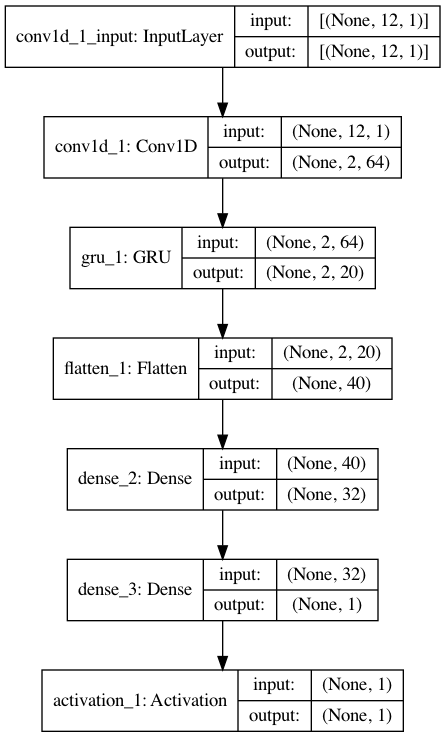

In [18]:
"""from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_conv_GRU_plot.png', show_shapes=True, show_layer_names=True)"""

# AUROC

In [12]:
import tensorflow
auc_roc = tensorflow.keras.metrics.AUC(name='auc_roc',num_thresholds=20000,curve='ROC')

# Conv1d Model

In [13]:
def create_model(filters=64,kernel_size=5):
    model = Sequential([
    Conv1D(filters=filters, kernel_size=kernel_size,strides=8, activation='tanh',padding='same', input_shape=(df_features.shape[1], 1)),
    ZeroPadding1D(padding=1),
    GRU(20, return_sequences=True),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(1, activation='swish'),
    Activation('sigmoid')])
    optimizer=SGD(lr=0.001)
    model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', auc_roc])
    return model

In [14]:
# Wrap Keras model so it can be used by scikit-learn
#kears_estimator = KerasClassifier(build_fn=create_model,epochs=100, batch_size=32, verbose=1)
kears_estimator = KerasClassifier(build_fn=create_model,epochs=50, batch_size=32, verbose=1)
#kears_estimator = KerasClassifier(build_fn=create_model, verbose=1)

In [15]:

# Empty dataframe to gather grid search results into 1 place
best_estimator = None
best_score = 0.0
best_params = {}
best_index = 0
df_result = None


parameters = {
        #'scaling__type_of_scaling': ['standard'],
        #'outlier__outlier_threshold': [0.0, 3.0],
        #'features__k': [12,15],
        #'balance__balancer_type': ['random-undersampler', 'allknn', 'nearmiss', 'instance-hardness-threshold'],
        #'balance__balancer_type': ['allknn', 'condensed-nn', 'neighbourhood-cleaning', 'one-sided-selection'],
        #'balance__balancer_type': ['allknn', 'one-sided-selection'],
        #'balance__balancer_type': ['allknn', 'smote-enn'],
        #'model__var_smoothing': [1e-6,1e-7,1e-8,1e-9,1e-10,1e-11,1e-12],
        'model__batch_size': [32, 48],#usually multiple of 8
        'model__epochs':[50,60],
        'model__filters':[8,16,32,64],
        'model__kernel_size':[3,5,7],
        #'model__batch_size': [60],
        #'model__epochs':[10],
        #'model__optimizer' : ['RMSprop', 'Adagrad', 'Adadelta','Adam']
    }

# Estimator Pipeline
pipeline = Pipeline(
      [
        #('progress', GridSearchProgressHack(verbose=False)),
        #('scaling',  FeatureScalerTransformer()),
        #('outlier',  WinsorizationOutlierTransformer()),
        #('features', SelectKBest()),
        #('features', SelectFromModel(estimator=LogisticRegression(solver='liblinear', penalty='l1', C=0.1), threshold=-np.inf)),
        #('balance',  ClassImbalanceTransformer()),
        ('model',    kears_estimator)
      ]
    )
    
# Cross Validation Splitter
cv_group_splitter = GroupKFold(n_splits=5)
    #cv_group_splitter = LeaveOneGroupOut()

    # perform the grid search for this vif selection
    # set up the search
search = GridSearchCV(
        estimator = pipeline,
        param_grid = parameters,
        scoring = ['roc_auc','accuracy'],
        cv = cv_group_splitter,
        #cv = 5,
        refit = 'roc_auc',
        verbose = 1)

search.fit(df_features, mind_wandered_label, groups=participant_ids)
#search.fit(df_features, mind_wandered_label)

df = pd.DataFrame(data=search.cv_results_)
    
    
if best_estimator is None:
    df_result = df
    best_estimator = search.best_estimator_
    best_score = search.best_score_
    best_params = search.best_params_
    best_index = search.best_index_
else:
    df_result = df_result.append(df, ignore_index=True)
    if search.best_score_ > best_score:
        best_estimator = search.best_estimator_
        best_score = search.best_score_
        best_params = search.best_params_
        best_index = search.best_index_  # todo this is only the index of this search

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Epoch 1/50
55/55 [==============================] - 2s 5ms/step - loss: 0.6888 - accuracy: 0.5950 - auc_roc: 0.6587
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.5801 - auc_roc: 0.6819
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.5655 - auc_roc: 0.6942
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.5497 - auc_roc: 0.6720
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.5745 - auc_roc: 0.7046
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.5415 - auc_roc: 0.6735
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.5507 - auc_roc: 0.6815
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6877 - accuracy: 0.5765 - auc_roc: 0.6976
Epoch 9/50

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 845us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6905 - accuracy: 0.5807 - auc_roc: 0.6501
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6897 - accuracy: 0.6106 - auc_roc: 0.6430
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.6042 - auc_roc: 0.6325
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.6131 - auc_roc: 0.6419
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.6108 - auc_roc: 0.6320
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6889 - accuracy: 0.6343 - auc_roc: 0.6551
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.6197 - auc_roc: 0.6401
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.6129 - auc_roc: 0.6322
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 802us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6890 - accuracy: 0.5347 - auc_roc: 0.6596
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6866 - accuracy: 0.5760 - auc_roc: 0.6451
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.5582 - auc_roc: 0.6380
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6884 - accuracy: 0.5484 - auc_roc: 0.6372
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.5149 - auc_roc: 0.6318
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6867 - accuracy: 0.5586 - auc_roc: 0.6367
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.5255 - auc_roc: 0.6328
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6864 - accuracy: 0.5571 - auc_roc: 0.6371
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 816us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 5ms/step - loss: 0.6958 - accuracy: 0.4434 - auc_roc: 0.6215
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6955 - accuracy: 0.4572 - auc_roc: 0.4504
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.4546 - auc_roc: 0.4553
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6956 - accuracy: 0.4450 - auc_roc: 0.4359
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6945 - accuracy: 0.4757 - auc_roc: 0.4720
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6952 - accuracy: 0.4622 - auc_roc: 0.4478
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.4895 - auc_roc: 0.4778
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.4728 - auc_roc: 0.4775
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 3s 5ms/step - loss: 0.6888 - accuracy: 0.6179 - auc_roc: 0.6387
Epoch 2/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6889 - accuracy: 0.6065 - auc_roc: 0.6485
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6880 - accuracy: 0.6274 - auc_roc: 0.6757
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.6321 - auc_roc: 0.6863
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6874 - accuracy: 0.6436 - auc_roc: 0.6868
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6883 - accuracy: 0.6264 - auc_roc: 0.6508
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6886 - accuracy: 0.6097 - auc_roc: 0.6435
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6869 - accuracy: 0.6488 - auc_roc: 0.6822
Epoch 9/50
55/55 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 872us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 6ms/step - loss: 0.6989 - accuracy: 0.3809 - auc_roc: 0.6025
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6986 - accuracy: 0.3720 - auc_roc: 0.3308
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6985 - accuracy: 0.3541 - auc_roc: 0.3224
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6985 - accuracy: 0.3716 - auc_roc: 0.3210
Epoch 5/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6986 - accuracy: 0.3749 - auc_roc: 0.3237
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6979 - accuracy: 0.3761 - auc_roc: 0.3324
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6978 - accuracy: 0.3878 - auc_roc: 0.3417
Epoch 8/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6978 - accuracy: 0.3661 - auc_roc: 0.3268
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 6ms/step - loss: 0.6944 - accuracy: 0.5183 - auc_roc: 0.5035
Epoch 2/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 0.5572 - auc_roc: 0.4423
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.5618 - auc_roc: 0.4489
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.5525 - auc_roc: 0.4373
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6933 - accuracy: 0.5422 - auc_roc: 0.4497
Epoch 6/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6933 - accuracy: 0.5302 - auc_roc: 0.4949
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5475 - auc_roc: 0.4777
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5410 - auc_roc: 0.4671
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 869us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 5ms/step - loss: 0.6969 - accuracy: 0.4605 - auc_roc: 0.6122
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6963 - accuracy: 0.4717 - auc_roc: 0.4383
Epoch 3/50
55/55 [==============================] - 0s 7ms/step - loss: 0.6964 - accuracy: 0.4694 - auc_roc: 0.4351
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6968 - accuracy: 0.4683 - auc_roc: 0.4264
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6963 - accuracy: 0.4837 - auc_roc: 0.4406
Epoch 6/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6955 - accuracy: 0.4862 - auc_roc: 0.4589
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6959 - accuracy: 0.4850 - auc_roc: 0.4472
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6949 - accuracy: 0.5094 - auc_roc: 0.4818
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 963us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 6ms/step - loss: 0.6926 - accuracy: 0.4928 - auc_roc: 0.6563
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6918 - accuracy: 0.5017 - auc_roc: 0.5948
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.4826 - auc_roc: 0.6027
Epoch 4/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.5115 - auc_roc: 0.5843
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.5171 - auc_roc: 0.6229
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6929 - accuracy: 0.4841 - auc_roc: 0.5778
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6916 - accuracy: 0.5040 - auc_roc: 0.6141
Epoch 8/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6912 - accuracy: 0.5067 - auc_roc: 0.6200
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 3s 6ms/step - loss: 0.6944 - accuracy: 0.5073 - auc_roc: 0.6235
Epoch 2/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.5306 - auc_roc: 0.5422
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.5204 - auc_roc: 0.5154
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5448 - auc_roc: 0.5548
Epoch 5/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5471 - auc_roc: 0.5695
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6927 - accuracy: 0.5381 - auc_roc: 0.5706
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5400 - auc_roc: 0.5675
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6921 - accuracy: 0.5578 - auc_roc: 0.5788
Epoch 9/50
55/55 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 5ms/step - loss: 0.6910 - accuracy: 0.5560 - auc_roc: 0.6871
Epoch 2/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6907 - accuracy: 0.5704 - auc_roc: 0.6145
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6907 - accuracy: 0.5509 - auc_roc: 0.6191
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6907 - accuracy: 0.5749 - auc_roc: 0.6188
Epoch 5/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6903 - accuracy: 0.5875 - auc_roc: 0.6334
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.5704 - auc_roc: 0.6037
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6901 - accuracy: 0.5854 - auc_roc: 0.6314
Epoch 8/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6895 - accuracy: 0.6043 - auc_roc: 0.6564
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 2ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 5ms/step - loss: 0.6880 - accuracy: 0.6319 - auc_roc: 0.7054
Epoch 2/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6872 - accuracy: 0.6576 - auc_roc: 0.6961
Epoch 3/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6872 - accuracy: 0.6534 - auc_roc: 0.6949
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6865 - accuracy: 0.6589 - auc_roc: 0.6850
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6862 - accuracy: 0.6604 - auc_roc: 0.6904
Epoch 6/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6863 - accuracy: 0.6496 - auc_roc: 0.6834
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6863 - accuracy: 0.6671 - auc_roc: 0.6936
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6864 - accuracy: 0.6468 - auc_roc: 0.6906
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 941us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 3s 6ms/step - loss: 0.6947 - accuracy: 0.4431 - auc_roc: 0.6683
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6947 - accuracy: 0.4551 - auc_roc: 0.3888
Epoch 3/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6947 - accuracy: 0.4488 - auc_roc: 0.3897
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6942 - accuracy: 0.4661 - auc_roc: 0.4254
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.4959 - auc_roc: 0.4499
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4942 - auc_roc: 0.4544
Epoch 7/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.4961 - auc_roc: 0.4649
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.4925 - auc_roc: 0.4669
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 935us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 5ms/step - loss: 0.6882 - accuracy: 0.6352 - auc_roc: 0.7253
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6879 - accuracy: 0.6374 - auc_roc: 0.7260
Epoch 3/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6880 - accuracy: 0.6587 - auc_roc: 0.7251
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6886 - accuracy: 0.6400 - auc_roc: 0.7007
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6879 - accuracy: 0.6463 - auc_roc: 0.7128
Epoch 6/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6878 - accuracy: 0.6552 - auc_roc: 0.7191
Epoch 7/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6870 - accuracy: 0.6748 - auc_roc: 0.7366
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6869 - accuracy: 0.6737 - auc_roc: 0.7366
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 921us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 3s 7ms/step - loss: 0.6939 - accuracy: 0.4949 - auc_roc: 0.6877
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5254 - auc_roc: 0.5083
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6935 - accuracy: 0.5057 - auc_roc: 0.5085
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6936 - accuracy: 0.4970 - auc_roc: 0.5002
Epoch 5/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5418 - auc_roc: 0.5508
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5297 - auc_roc: 0.5375
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6925 - accuracy: 0.5385 - auc_roc: 0.5393
Epoch 8/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5296 - auc_roc: 0.5767
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 3s 5ms/step - loss: 0.6948 - accuracy: 0.4972 - auc_roc: 0.6464
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.5104 - auc_roc: 0.5070
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6939 - accuracy: 0.5059 - auc_roc: 0.5027
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.5166 - auc_roc: 0.4950
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6934 - accuracy: 0.5229 - auc_roc: 0.5171
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.5058 - auc_roc: 0.5112
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6938 - accuracy: 0.5062 - auc_roc: 0.5052
Epoch 8/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5418 - auc_roc: 0.5298
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 885us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 3s 7ms/step - loss: 0.6984 - accuracy: 0.3775 - auc_roc: 0.5660
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6986 - accuracy: 0.3922 - auc_roc: 0.2778
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6977 - accuracy: 0.3989 - auc_roc: 0.3039
Epoch 4/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6972 - accuracy: 0.4229 - auc_roc: 0.3087
Epoch 5/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6971 - accuracy: 0.4417 - auc_roc: 0.3088
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6967 - accuracy: 0.4386 - auc_roc: 0.3086
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6963 - accuracy: 0.4677 - auc_roc: 0.3228
Epoch 8/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6963 - accuracy: 0.4666 - auc_roc: 0.3194
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 3s 7ms/step - loss: 0.6901 - accuracy: 0.5804 - auc_roc: 0.6444
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6896 - accuracy: 0.6003 - auc_roc: 0.6317
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6888 - accuracy: 0.6216 - auc_roc: 0.6496
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6881 - accuracy: 0.6239 - auc_roc: 0.6691
Epoch 5/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6884 - accuracy: 0.6166 - auc_roc: 0.6602
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.6276 - auc_roc: 0.6660
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6878 - accuracy: 0.6237 - auc_roc: 0.6591
Epoch 8/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6870 - accuracy: 0.6338 - auc_roc: 0.6813
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 6ms/step - loss: 0.7004 - accuracy: 0.3455 - auc_roc: 0.6381
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.7002 - accuracy: 0.3438 - auc_roc: 0.3055
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6993 - accuracy: 0.3639 - auc_roc: 0.3159
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6984 - accuracy: 0.3742 - auc_roc: 0.3334
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6982 - accuracy: 0.3980 - auc_roc: 0.3419
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6978 - accuracy: 0.4112 - auc_roc: 0.3506
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6974 - accuracy: 0.4170 - auc_roc: 0.3576
Epoch 8/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6975 - accuracy: 0.4142 - auc_roc: 0.3304
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 819us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6900 - accuracy: 0.5488 - auc_roc: 0.6443
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6905 - accuracy: 0.5344 - auc_roc: 0.5566
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.5353 - auc_roc: 0.5719
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5670 - auc_roc: 0.6001
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.5442 - auc_roc: 0.5704
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6896 - accuracy: 0.5452 - auc_roc: 0.5879
Epoch 7/50
55/55 [==============================] - 0s 3ms/step - loss: 0.6886 - accuracy: 0.5696 - auc_roc: 0.5961
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5591 - auc_roc: 0.5928
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 855us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 5ms/step - loss: 0.6935 - accuracy: 0.4734 - auc_roc: 0.6039
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.4861 - auc_roc: 0.5118
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.4630 - auc_roc: 0.4831
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.4723 - auc_roc: 0.4997
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5009 - auc_roc: 0.5183
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.4885 - auc_roc: 0.4995
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.4720 - auc_roc: 0.4984
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5015 - auc_roc: 0.5307
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 898us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6942 - accuracy: 0.4981 - auc_roc: 0.5802
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.5022 - auc_roc: 0.4736
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.5028 - auc_roc: 0.4668
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.5197 - auc_roc: 0.4831
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5298 - auc_roc: 0.4910
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.5191 - auc_roc: 0.4929
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5270 - auc_roc: 0.4897
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.5550 - auc_roc: 0.5191
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 896us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6913 - accuracy: 0.5498 - auc_roc: 0.6538
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.5607 - auc_roc: 0.5745
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.5508 - auc_roc: 0.5807
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6904 - accuracy: 0.5765 - auc_roc: 0.6080
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6902 - accuracy: 0.5737 - auc_roc: 0.6097
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6903 - accuracy: 0.5771 - auc_roc: 0.6062
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.5822 - auc_roc: 0.6262
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6897 - accuracy: 0.5815 - auc_roc: 0.6190
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 896us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6919 - accuracy: 0.4871 - auc_roc: 0.6814
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.4669 - auc_roc: 0.5554
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.4763 - auc_roc: 0.5886
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.4691 - auc_roc: 0.6035
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.4677 - auc_roc: 0.6236
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.4823 - auc_roc: 0.6254
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5024 - auc_roc: 0.6307
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.4693 - auc_roc: 0.6610
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 842us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6961 - accuracy: 0.4571 - auc_roc: 0.6222
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6955 - accuracy: 0.4508 - auc_roc: 0.4095
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6956 - accuracy: 0.4597 - auc_roc: 0.4125
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6952 - accuracy: 0.4736 - auc_roc: 0.4241
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6952 - accuracy: 0.4555 - auc_roc: 0.4448
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.4869 - auc_roc: 0.4469
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.4757 - auc_roc: 0.4181
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6949 - accuracy: 0.4635 - auc_roc: 0.4310
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 902us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6873 - accuracy: 0.6241 - auc_roc: 0.6609
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.6146 - auc_roc: 0.6715
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.6413 - auc_roc: 0.6794
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.6307 - auc_roc: 0.6756
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.6383 - auc_roc: 0.7043
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.6153 - auc_roc: 0.6675
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6849 - accuracy: 0.6437 - auc_roc: 0.6911
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.6372 - auc_roc: 0.6866
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 904us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6941 - accuracy: 0.4328 - auc_roc: 0.6672
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.4280 - auc_roc: 0.5056
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.4483 - auc_roc: 0.5152
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.4746 - auc_roc: 0.5301
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.4962 - auc_roc: 0.5384
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.4994 - auc_roc: 0.5567
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5393 - auc_roc: 0.5703
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.5293 - auc_roc: 0.5625
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 879us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6955 - accuracy: 0.4921 - auc_roc: 0.6558
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6955 - accuracy: 0.4920 - auc_roc: 0.4588
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6945 - accuracy: 0.5130 - auc_roc: 0.4838
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6947 - accuracy: 0.4942 - auc_roc: 0.4803
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.5312 - auc_roc: 0.5055
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.5143 - auc_roc: 0.5025
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5265 - auc_roc: 0.5350
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.5050 - auc_roc: 0.4850
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 884us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6901 - accuracy: 0.5759 - auc_roc: 0.7003
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6896 - accuracy: 0.6039 - auc_roc: 0.6303
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.6131 - auc_roc: 0.6463
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.6093 - auc_roc: 0.6317
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6884 - accuracy: 0.6150 - auc_roc: 0.6486
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.6297 - auc_roc: 0.6616
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6877 - accuracy: 0.6369 - auc_roc: 0.6715
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6875 - accuracy: 0.6365 - auc_roc: 0.6631
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 903us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6886 - accuracy: 0.5993 - auc_roc: 0.7181
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6889 - accuracy: 0.6059 - auc_roc: 0.6842
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6886 - accuracy: 0.6228 - auc_roc: 0.6958
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.6216 - auc_roc: 0.6982
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.6338 - auc_roc: 0.7137
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6880 - accuracy: 0.6298 - auc_roc: 0.6863
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6880 - accuracy: 0.6311 - auc_roc: 0.6876
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.6514 - auc_roc: 0.7024
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 889us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6893 - accuracy: 0.5901 - auc_roc: 0.6916
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.5646 - auc_roc: 0.6036
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.5774 - auc_roc: 0.6082
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6886 - accuracy: 0.5955 - auc_roc: 0.6326
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.5982 - auc_roc: 0.6285
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5912 - auc_roc: 0.6190
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6884 - accuracy: 0.6045 - auc_roc: 0.6363
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.6194 - auc_roc: 0.6533
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 963us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6971 - accuracy: 0.4096 - auc_roc: 0.6233
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6962 - accuracy: 0.4483 - auc_roc: 0.3968
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6953 - accuracy: 0.4648 - auc_roc: 0.4287
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6953 - accuracy: 0.4624 - auc_roc: 0.4301
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6951 - accuracy: 0.4552 - auc_roc: 0.4201
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.4953 - auc_roc: 0.4669
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6941 - accuracy: 0.4913 - auc_roc: 0.4583
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.5029 - auc_roc: 0.4716
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 815us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6890 - accuracy: 0.5732 - auc_roc: 0.6859
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.5628 - auc_roc: 0.6759
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.5561 - auc_roc: 0.6657
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.5744 - auc_roc: 0.6708
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6877 - accuracy: 0.5698 - auc_roc: 0.6868
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.5813 - auc_roc: 0.6912
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6873 - accuracy: 0.5865 - auc_roc: 0.7172
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6881 - accuracy: 0.5715 - auc_roc: 0.6780
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 804us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 5ms/step - loss: 0.6908 - accuracy: 0.4963 - auc_roc: 0.6981
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.4948 - auc_roc: 0.5488
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.5199 - auc_roc: 0.5863
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6904 - accuracy: 0.5055 - auc_roc: 0.5807
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5228 - auc_roc: 0.5990
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.5258 - auc_roc: 0.5812
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6897 - accuracy: 0.5266 - auc_roc: 0.5818
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.5301 - auc_roc: 0.5923
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 869us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6952 - accuracy: 0.4530 - auc_roc: 0.6447
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.4841 - auc_roc: 0.4931
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.4540 - auc_roc: 0.5249
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.4696 - auc_roc: 0.5226
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.4902 - auc_roc: 0.5425
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.4937 - auc_roc: 0.5425
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.4897 - auc_roc: 0.5548
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5205 - auc_roc: 0.5764
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 5ms/step - loss: 0.6950 - accuracy: 0.4995 - auc_roc: 0.6216
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.5050 - auc_roc: 0.5475
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.5258 - auc_roc: 0.5200
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5230 - auc_roc: 0.5464
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5213 - auc_roc: 0.5256
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.5179 - auc_roc: 0.5262
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5236 - auc_roc: 0.5471
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5392 - auc_roc: 0.5376
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 904us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6940 - accuracy: 0.5487 - auc_roc: 0.6080
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5583 - auc_roc: 0.4666
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.5425 - auc_roc: 0.4796
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6941 - accuracy: 0.5377 - auc_roc: 0.4750
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5519 - auc_roc: 0.4738
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5535 - auc_roc: 0.4972
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5443 - auc_roc: 0.5095
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.5795 - auc_roc: 0.5013
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 761us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6955 - accuracy: 0.4506 - auc_roc: 0.6197
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6954 - accuracy: 0.4435 - auc_roc: 0.4092
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.4729 - auc_roc: 0.4250
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6947 - accuracy: 0.4637 - auc_roc: 0.4039
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6941 - accuracy: 0.4793 - auc_roc: 0.4256
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.4817 - auc_roc: 0.4453
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.4879 - auc_roc: 0.4658
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.4917 - auc_roc: 0.4548
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 826us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6931 - accuracy: 0.4873 - auc_roc: 0.6769
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.4774 - auc_roc: 0.4724
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5043 - auc_roc: 0.4968
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5193 - auc_roc: 0.5217
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5304 - auc_roc: 0.5204
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5255 - auc_roc: 0.5160
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5367 - auc_roc: 0.5390
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6916 - accuracy: 0.5478 - auc_roc: 0.5417
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 886us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6980 - accuracy: 0.4108 - auc_roc: 0.6188
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6979 - accuracy: 0.4008 - auc_roc: 0.3235
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6978 - accuracy: 0.4238 - auc_roc: 0.3417
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6968 - accuracy: 0.4472 - auc_roc: 0.3612
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6967 - accuracy: 0.4537 - auc_roc: 0.3666
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6963 - accuracy: 0.4571 - auc_roc: 0.3750
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6965 - accuracy: 0.4473 - auc_roc: 0.3714
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6960 - accuracy: 0.4685 - auc_roc: 0.3914
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 776us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6882 - accuracy: 0.6379 - auc_roc: 0.6448
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.6261 - auc_roc: 0.6858
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6872 - accuracy: 0.6407 - auc_roc: 0.7000
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 0.6480 - auc_roc: 0.7057
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6869 - accuracy: 0.6346 - auc_roc: 0.7131
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 0.6317 - auc_roc: 0.6966
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6865 - accuracy: 0.6523 - auc_roc: 0.7169
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6872 - accuracy: 0.6149 - auc_roc: 0.6906
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 883us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6922 - accuracy: 0.5091 - auc_roc: 0.7038
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.5588 - auc_roc: 0.6025
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.5556 - auc_roc: 0.6070
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.5769 - auc_roc: 0.6249
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.5936 - auc_roc: 0.6610
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.5963 - auc_roc: 0.6324
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.6134 - auc_roc: 0.6654
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.6275 - auc_roc: 0.6808
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


14/14 [==============================] - 0s 874us/step
Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6873 - accuracy: 0.5248 - auc_roc: 0.7150
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6880 - accuracy: 0.5238 - auc_roc: 0.6370
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6873 - accuracy: 0.5343 - auc_roc: 0.6376
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6886 - accuracy: 0.5061 - auc_roc: 0.6277
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6866 - accuracy: 0.5400 - auc_roc: 0.6632
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6872 - accuracy: 0.5246 - auc_roc: 0.6778
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6864 - accuracy: 0.5355 - auc_roc: 0.6779
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6857 - accuracy: 0.5381 - auc_roc: 0.6707
Epoch 9/50
55/55 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 906us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 5ms/step - loss: 0.6916 - accuracy: 0.5685 - auc_roc: 0.6691
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.5991 - auc_roc: 0.5633
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.6042 - auc_roc: 0.5804
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.5928 - auc_roc: 0.5957
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.6146 - auc_roc: 0.6115
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.6271 - auc_roc: 0.6434
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.6201 - auc_roc: 0.6377
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.6216 - auc_roc: 0.6605
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 891us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6936 - accuracy: 0.4994 - auc_roc: 0.6988
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5289 - auc_roc: 0.5435
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5223 - auc_roc: 0.5487
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5362 - auc_roc: 0.5707
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5563 - auc_roc: 0.5935
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5647 - auc_roc: 0.5991
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.5682 - auc_roc: 0.5978
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.5705 - auc_roc: 0.6000
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 885us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 5ms/step - loss: 0.6907 - accuracy: 0.5360 - auc_roc: 0.6821
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.5331 - auc_roc: 0.5917
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.5432 - auc_roc: 0.6394
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6903 - accuracy: 0.5218 - auc_roc: 0.6233
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.5410 - auc_roc: 0.6492
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.5188 - auc_roc: 0.6537
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.5567 - auc_roc: 0.6755
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.5341 - auc_roc: 0.6643
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 903us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 5ms/step - loss: 0.6943 - accuracy: 0.4627 - auc_roc: 0.6497
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.4813 - auc_roc: 0.4818
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.4717 - auc_roc: 0.4818
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4866 - auc_roc: 0.5058
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.4779 - auc_roc: 0.4946
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.5007 - auc_roc: 0.5131
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5296 - auc_roc: 0.5442
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5424 - auc_roc: 0.5412
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 989us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 5ms/step - loss: 0.6957 - accuracy: 0.4706 - auc_roc: 0.6531
Epoch 2/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6956 - accuracy: 0.4659 - auc_roc: 0.4418
Epoch 3/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6955 - accuracy: 0.4682 - auc_roc: 0.4490
Epoch 4/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6954 - accuracy: 0.4611 - auc_roc: 0.4697
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6946 - accuracy: 0.4761 - auc_roc: 0.4878
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6941 - accuracy: 0.4986 - auc_roc: 0.4909
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6937 - accuracy: 0.4942 - auc_roc: 0.5225
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.5112 - auc_roc: 0.5249
Epoch 9/50
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 789us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 5ms/step - loss: 0.6922 - accuracy: 0.5582 - auc_roc: 0.6892
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5582 - auc_roc: 0.6084
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6916 - accuracy: 0.5797 - auc_roc: 0.6107
Epoch 4/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6910 - accuracy: 0.5945 - auc_roc: 0.6273
Epoch 5/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6909 - accuracy: 0.5980 - auc_roc: 0.6343
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6908 - accuracy: 0.5948 - auc_roc: 0.6340
Epoch 7/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6904 - accuracy: 0.5996 - auc_roc: 0.6515
Epoch 8/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.6114 - auc_roc: 0.6499
Epoch 9/50
55/55 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 7ms/step - loss: 0.6933 - accuracy: 0.5019 - auc_roc: 0.6755
Epoch 2/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5079 - auc_roc: 0.4846
Epoch 3/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5204 - auc_roc: 0.4883
Epoch 4/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.5056 - auc_roc: 0.4956
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5352 - auc_roc: 0.5148
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5400 - auc_roc: 0.5267
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5376 - auc_roc: 0.5367
Epoch 8/50
55/55 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.5311 - auc_roc: 0.5433
Epoch 9/50
55/55 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 852us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 5ms/step - loss: 0.6922 - accuracy: 0.4712 - auc_roc: 0.6496
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.4553 - auc_roc: 0.4960
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.4545 - auc_roc: 0.4990
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.4648 - auc_roc: 0.5175
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6903 - accuracy: 0.5070 - auc_roc: 0.5545
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6903 - accuracy: 0.4946 - auc_roc: 0.5718
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.4906 - auc_roc: 0.5685
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.4965 - auc_roc: 0.5838
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 792us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 5ms/step - loss: 0.6925 - accuracy: 0.5500 - auc_roc: 0.6279
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.5822 - auc_roc: 0.5032
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5495 - auc_roc: 0.5092
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5470 - auc_roc: 0.5454
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5601 - auc_roc: 0.5404
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.5628 - auc_roc: 0.5332
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.5603 - auc_roc: 0.5438
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.5772 - auc_roc: 0.5662
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 5ms/step - loss: 0.6893 - accuracy: 0.5578 - auc_roc: 0.7115
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.5440 - auc_roc: 0.6256
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5750 - auc_roc: 0.6411
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5599 - auc_roc: 0.6434
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.5584 - auc_roc: 0.6649
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.5690 - auc_roc: 0.6738
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.5730 - auc_roc: 0.6936
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 0.5815 - auc_roc: 0.7011
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 836us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6945 - accuracy: 0.4577 - auc_roc: 0.6730
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.4317 - auc_roc: 0.4231
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6945 - accuracy: 0.4429 - auc_roc: 0.4421
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.4951 - auc_roc: 0.4869
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.5191 - auc_roc: 0.5031
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5203 - auc_roc: 0.5257
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5404 - auc_roc: 0.5358
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5290 - auc_roc: 0.5382
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 864us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6922 - accuracy: 0.5039 - auc_roc: 0.6699
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.5233 - auc_roc: 0.5314
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5001 - auc_roc: 0.5139
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5249 - auc_roc: 0.5141
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.5379 - auc_roc: 0.5543
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.5497 - auc_roc: 0.5641
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.5438 - auc_roc: 0.5698
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.5192 - auc_roc: 0.5411
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 908us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 5ms/step - loss: 0.6916 - accuracy: 0.4974 - auc_roc: 0.6501
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5069 - auc_roc: 0.5395
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.5514 - auc_roc: 0.5956
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.5434 - auc_roc: 0.5834
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.5753 - auc_roc: 0.6254
Epoch 6/50
55/55 [==============================] - 0s 5ms/step - loss: 0.6899 - accuracy: 0.5832 - auc_roc: 0.6279
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.6122 - auc_roc: 0.6560
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6887 - accuracy: 0.6285 - auc_roc: 0.6766
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 912us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6898 - accuracy: 0.5993 - auc_roc: 0.7038
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6897 - accuracy: 0.5962 - auc_roc: 0.6116
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.6206 - auc_roc: 0.6379
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5922 - auc_roc: 0.6093
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.6387 - auc_roc: 0.6666
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6873 - accuracy: 0.6518 - auc_roc: 0.6632
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.6409 - auc_roc: 0.6609
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6866 - accuracy: 0.6608 - auc_roc: 0.6754
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 987us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 5ms/step - loss: 0.6939 - accuracy: 0.4643 - auc_roc: 0.6902
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5002 - auc_roc: 0.4798
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.4752 - auc_roc: 0.4676
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.4955 - auc_roc: 0.5068
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.5316 - auc_roc: 0.5628
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.5238 - auc_roc: 0.5658
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6905 - accuracy: 0.5303 - auc_roc: 0.5943
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5401 - auc_roc: 0.6194
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 929us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 5ms/step - loss: 0.6960 - accuracy: 0.3883 - auc_roc: 0.6693
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6957 - accuracy: 0.3924 - auc_roc: 0.3615
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6957 - accuracy: 0.3890 - auc_roc: 0.3588
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.4131 - auc_roc: 0.3812
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6949 - accuracy: 0.4143 - auc_roc: 0.3781
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.4345 - auc_roc: 0.4155
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.4711 - auc_roc: 0.4565
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.4754 - auc_roc: 0.4712
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 924us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
55/55 [==============================] - 2s 4ms/step - loss: 0.6990 - accuracy: 0.4328 - auc_roc: 0.6434
Epoch 2/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6988 - accuracy: 0.4625 - auc_roc: 0.4193
Epoch 3/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6982 - accuracy: 0.4479 - auc_roc: 0.4272
Epoch 4/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6985 - accuracy: 0.4502 - auc_roc: 0.4413
Epoch 5/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6965 - accuracy: 0.4730 - auc_roc: 0.4580
Epoch 6/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6967 - accuracy: 0.4970 - auc_roc: 0.4699
Epoch 7/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6959 - accuracy: 0.4928 - auc_roc: 0.4842
Epoch 8/50
55/55 [==============================] - 0s 4ms/step - loss: 0.6972 - accuracy: 0.4939 - auc_roc: 0.4813
Epoch 9/50
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 749us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6941 - accuracy: 0.4978 - auc_roc: 0.6467
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6940 - accuracy: 0.5014 - auc_roc: 0.4781
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.5140 - auc_roc: 0.5043
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.5171 - auc_roc: 0.5183
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5109 - auc_roc: 0.5160
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.5164 - auc_roc: 0.5008
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5330 - auc_roc: 0.5185
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5370 - auc_roc: 0.5284
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 817us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6951 - accuracy: 0.4256 - auc_roc: 0.6306
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.4206 - auc_roc: 0.3784
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6949 - accuracy: 0.4189 - auc_roc: 0.3648
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.4146 - auc_roc: 0.3970
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.4302 - auc_roc: 0.4127
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.4559 - auc_roc: 0.4457
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.4497 - auc_roc: 0.4390
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.4858 - auc_roc: 0.4861
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 883us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6936 - accuracy: 0.5300 - auc_roc: 0.6242
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5400 - auc_roc: 0.4131
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.5100 - auc_roc: 0.4025
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5179 - auc_roc: 0.4086
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5328 - auc_roc: 0.4350
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5369 - auc_roc: 0.4491
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.5333 - auc_roc: 0.4790
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.5576 - auc_roc: 0.4911
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 890us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6876 - accuracy: 0.6221 - auc_roc: 0.6687
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6873 - accuracy: 0.6006 - auc_roc: 0.6523
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6881 - accuracy: 0.6077 - auc_roc: 0.6443
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6867 - accuracy: 0.6130 - auc_roc: 0.6684
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6870 - accuracy: 0.6185 - auc_roc: 0.6585
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.6051 - auc_roc: 0.6595
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.6141 - auc_roc: 0.6769
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6856 - accuracy: 0.6230 - auc_roc: 0.6794
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6912 - accuracy: 0.5370 - auc_roc: 0.6678
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.5297 - auc_roc: 0.5307
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6897 - accuracy: 0.5514 - auc_roc: 0.5565
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.5405 - auc_roc: 0.5475
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.5408 - auc_roc: 0.5565
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5377 - auc_roc: 0.5641
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.5732 - auc_roc: 0.5942
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.5619 - auc_roc: 0.5759
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 752us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6957 - accuracy: 0.4873 - auc_roc: 0.6002
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6957 - accuracy: 0.4846 - auc_roc: 0.4168
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.5008 - auc_roc: 0.4505
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6956 - accuracy: 0.4982 - auc_roc: 0.4406
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6951 - accuracy: 0.4976 - auc_roc: 0.4700
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.5095 - auc_roc: 0.4716
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6940 - accuracy: 0.5267 - auc_roc: 0.4971
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.5052 - auc_roc: 0.4706
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 873us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6933 - accuracy: 0.4534 - auc_roc: 0.6115
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.4476 - auc_roc: 0.5261
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4677 - auc_roc: 0.5253
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.4533 - auc_roc: 0.5414
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.4761 - auc_roc: 0.5503
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.4639 - auc_roc: 0.5680
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.4786 - auc_roc: 0.5710
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.4813 - auc_roc: 0.5523
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 814us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6955 - accuracy: 0.4663 - auc_roc: 0.6461
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6945 - accuracy: 0.4776 - auc_roc: 0.3727
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6949 - accuracy: 0.4670 - auc_roc: 0.3704
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6945 - accuracy: 0.4603 - auc_roc: 0.3888
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6941 - accuracy: 0.4696 - auc_roc: 0.4018
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.4575 - auc_roc: 0.4051
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.4848 - auc_roc: 0.4119
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5040 - auc_roc: 0.4399
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 884us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6890 - accuracy: 0.5946 - auc_roc: 0.6852
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6902 - accuracy: 0.5815 - auc_roc: 0.5967
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.6148 - auc_roc: 0.6402
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.6183 - auc_roc: 0.6524
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.6199 - auc_roc: 0.6393
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6889 - accuracy: 0.6057 - auc_roc: 0.6253
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.6295 - auc_roc: 0.6407
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6889 - accuracy: 0.6044 - auc_roc: 0.6228
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 870us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6923 - accuracy: 0.5239 - auc_roc: 0.6490
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6907 - accuracy: 0.5654 - auc_roc: 0.5263
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5258 - auc_roc: 0.5239
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5172 - auc_roc: 0.5161
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6916 - accuracy: 0.5349 - auc_roc: 0.5224
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6912 - accuracy: 0.5336 - auc_roc: 0.5307
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.5374 - auc_roc: 0.5266
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6918 - accuracy: 0.5254 - auc_roc: 0.5121
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 861us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6941 - accuracy: 0.4792 - auc_roc: 0.5603
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.4650 - auc_roc: 0.4671
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.4916 - auc_roc: 0.4802
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.4969 - auc_roc: 0.4760
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5075 - auc_roc: 0.5011
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.4922 - auc_roc: 0.5182
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5026 - auc_roc: 0.5080
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.5191 - auc_roc: 0.5405
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 914us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6862 - accuracy: 0.6172 - auc_roc: 0.6755
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6865 - accuracy: 0.6066 - auc_roc: 0.6428
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6869 - accuracy: 0.6023 - auc_roc: 0.6299
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6866 - accuracy: 0.6037 - auc_roc: 0.6433
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6864 - accuracy: 0.6089 - auc_roc: 0.6418
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6855 - accuracy: 0.6233 - auc_roc: 0.6533
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6870 - accuracy: 0.6031 - auc_roc: 0.6324
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6843 - accuracy: 0.6373 - auc_roc: 0.6783
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 906us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6930 - accuracy: 0.4642 - auc_roc: 0.6636
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.4644 - auc_roc: 0.4553
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.4851 - auc_roc: 0.4642
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5048 - auc_roc: 0.5060
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5028 - auc_roc: 0.4990
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.5078 - auc_roc: 0.5138
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.4995 - auc_roc: 0.5085
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.5220 - auc_roc: 0.5280
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 924us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6943 - accuracy: 0.5560 - auc_roc: 0.6534
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.5425 - auc_roc: 0.4651
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.5424 - auc_roc: 0.4617
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5663 - auc_roc: 0.4983
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5739 - auc_roc: 0.5031
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5694 - auc_roc: 0.4930
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.5464 - auc_roc: 0.4879
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6931 - accuracy: 0.5433 - auc_roc: 0.5073
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 842us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6946 - accuracy: 0.4368 - auc_roc: 0.6403
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.4387 - auc_roc: 0.4482
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.4407 - auc_roc: 0.4327
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.4584 - auc_roc: 0.4580
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.4703 - auc_roc: 0.4777
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.4747 - auc_roc: 0.4771
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.4873 - auc_roc: 0.4995
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.4630 - auc_roc: 0.4682
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 770us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6996 - accuracy: 0.3918 - auc_roc: 0.6155
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6993 - accuracy: 0.3989 - auc_roc: 0.3516
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6989 - accuracy: 0.4106 - auc_roc: 0.3560
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6980 - accuracy: 0.4161 - auc_roc: 0.3781
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6979 - accuracy: 0.4190 - auc_roc: 0.3685
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6983 - accuracy: 0.4042 - auc_roc: 0.3682
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6974 - accuracy: 0.4179 - auc_roc: 0.3754
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6980 - accuracy: 0.4050 - auc_roc: 0.3745
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 753us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6895 - accuracy: 0.6275 - auc_roc: 0.6714
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6889 - accuracy: 0.6407 - auc_roc: 0.6696
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6884 - accuracy: 0.6557 - auc_roc: 0.6795
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.6648 - auc_roc: 0.6782
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6877 - accuracy: 0.6593 - auc_roc: 0.6906
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.6333 - auc_roc: 0.6676
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6864 - accuracy: 0.6897 - auc_roc: 0.7177
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6875 - accuracy: 0.6543 - auc_roc: 0.6837
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 743us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6970 - accuracy: 0.4547 - auc_roc: 0.6602
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6974 - accuracy: 0.4565 - auc_roc: 0.4145
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6971 - accuracy: 0.4537 - auc_roc: 0.4154
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6969 - accuracy: 0.4702 - auc_roc: 0.4249
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6962 - accuracy: 0.4747 - auc_roc: 0.4360
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6960 - accuracy: 0.4852 - auc_roc: 0.4516
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6954 - accuracy: 0.4946 - auc_roc: 0.4668
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6952 - accuracy: 0.4928 - auc_roc: 0.4665
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 837us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6940 - accuracy: 0.4927 - auc_roc: 0.6257
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.5029 - auc_roc: 0.4816
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.4939 - auc_roc: 0.4692
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6940 - accuracy: 0.5162 - auc_roc: 0.4818
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5170 - auc_roc: 0.4915
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.5222 - auc_roc: 0.4923
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.5086 - auc_roc: 0.4735
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5259 - auc_roc: 0.4889
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 826us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6935 - accuracy: 0.4815 - auc_roc: 0.6014
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.4682 - auc_roc: 0.4434
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.4559 - auc_roc: 0.4454
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.4786 - auc_roc: 0.4609
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5031 - auc_roc: 0.4989
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6923 - accuracy: 0.5033 - auc_roc: 0.4761
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.4711 - auc_roc: 0.4691
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.4846 - auc_roc: 0.4548
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 939us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6823 - accuracy: 0.6399 - auc_roc: 0.6617
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6826 - accuracy: 0.6223 - auc_roc: 0.6662
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6825 - accuracy: 0.6195 - auc_roc: 0.6709
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6827 - accuracy: 0.6219 - auc_roc: 0.6683
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6809 - accuracy: 0.6275 - auc_roc: 0.6776
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6807 - accuracy: 0.6196 - auc_roc: 0.6821
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6815 - accuracy: 0.6255 - auc_roc: 0.6779
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6812 - accuracy: 0.6387 - auc_roc: 0.6915
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 889us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6906 - accuracy: 0.5259 - auc_roc: 0.6785
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6903 - accuracy: 0.5551 - auc_roc: 0.6471
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.5568 - auc_roc: 0.6371
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.5800 - auc_roc: 0.6573
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.6071 - auc_roc: 0.6789
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6889 - accuracy: 0.6118 - auc_roc: 0.6627
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.6172 - auc_roc: 0.6623
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6882 - accuracy: 0.6390 - auc_roc: 0.6779
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 770us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6956 - accuracy: 0.4625 - auc_roc: 0.6694
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6954 - accuracy: 0.4631 - auc_roc: 0.3913
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.4687 - auc_roc: 0.3892
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.4847 - auc_roc: 0.4023
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6938 - accuracy: 0.4951 - auc_roc: 0.4379
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.4768 - auc_roc: 0.4111
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5179 - auc_roc: 0.4222
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.4948 - auc_roc: 0.4367
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 857us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6943 - accuracy: 0.4555 - auc_roc: 0.6437
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.5117 - auc_roc: 0.4895
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5269 - auc_roc: 0.5045
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.5139 - auc_roc: 0.4850
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5435 - auc_roc: 0.5222
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6914 - accuracy: 0.5753 - auc_roc: 0.5584
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5591 - auc_roc: 0.5560
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5522 - auc_roc: 0.5534
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 782us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6960 - accuracy: 0.4321 - auc_roc: 0.6485
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6964 - accuracy: 0.4237 - auc_roc: 0.3989
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.4521 - auc_roc: 0.4438
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.4566 - auc_roc: 0.4429
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6955 - accuracy: 0.4262 - auc_roc: 0.4266
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6951 - accuracy: 0.4387 - auc_roc: 0.4333
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6941 - accuracy: 0.4730 - auc_roc: 0.4674
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.4599 - auc_roc: 0.4402
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 838us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6833 - accuracy: 0.6498 - auc_roc: 0.7012
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6833 - accuracy: 0.6524 - auc_roc: 0.6935
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6815 - accuracy: 0.6758 - auc_roc: 0.7239
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6812 - accuracy: 0.6800 - auc_roc: 0.7296
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6808 - accuracy: 0.6706 - auc_roc: 0.7257
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6819 - accuracy: 0.6498 - auc_roc: 0.7004
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6813 - accuracy: 0.6665 - auc_roc: 0.7131
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6801 - accuracy: 0.6690 - auc_roc: 0.7280
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 883us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6872 - accuracy: 0.6187 - auc_roc: 0.7266
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.6289 - auc_roc: 0.7432
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6856 - accuracy: 0.6526 - auc_roc: 0.7587
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6863 - accuracy: 0.6455 - auc_roc: 0.7601
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6864 - accuracy: 0.6432 - auc_roc: 0.7436
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6849 - accuracy: 0.6687 - auc_roc: 0.7733
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6859 - accuracy: 0.6587 - auc_roc: 0.7565
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.6696 - auc_roc: 0.7404
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 889us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6928 - accuracy: 0.5109 - auc_roc: 0.7088
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5237 - auc_roc: 0.5494
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6921 - accuracy: 0.5242 - auc_roc: 0.5833
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6919 - accuracy: 0.5421 - auc_roc: 0.5861
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6918 - accuracy: 0.5404 - auc_roc: 0.5867
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6913 - accuracy: 0.5678 - auc_roc: 0.6095
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6911 - accuracy: 0.5741 - auc_roc: 0.6114
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6903 - accuracy: 0.5965 - auc_roc: 0.6375
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 898us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6923 - accuracy: 0.4798 - auc_roc: 0.7117
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6930 - accuracy: 0.4573 - auc_roc: 0.6073
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.4926 - auc_roc: 0.6053
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.4614 - auc_roc: 0.6363
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.4693 - auc_roc: 0.6421
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6909 - accuracy: 0.4596 - auc_roc: 0.6497
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.4981 - auc_roc: 0.6494
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6886 - accuracy: 0.5047 - auc_roc: 0.6998
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 756us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6975 - accuracy: 0.4815 - auc_roc: 0.6439
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6970 - accuracy: 0.4873 - auc_roc: 0.3774
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6967 - accuracy: 0.4858 - auc_roc: 0.3786
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6965 - accuracy: 0.4697 - auc_roc: 0.4053
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6960 - accuracy: 0.4856 - auc_roc: 0.4026
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6967 - accuracy: 0.4701 - auc_roc: 0.3919
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6964 - accuracy: 0.4760 - auc_roc: 0.4050
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6960 - accuracy: 0.4832 - auc_roc: 0.4016
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 864us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6977 - accuracy: 0.4089 - auc_roc: 0.5582
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6970 - accuracy: 0.4128 - auc_roc: 0.3460
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6974 - accuracy: 0.4031 - auc_roc: 0.3417
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6957 - accuracy: 0.4137 - auc_roc: 0.3815
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6960 - accuracy: 0.4136 - auc_roc: 0.3743
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6955 - accuracy: 0.4352 - auc_roc: 0.3918
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6954 - accuracy: 0.4358 - auc_roc: 0.3979
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.4488 - auc_roc: 0.4264
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 896us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6945 - accuracy: 0.4712 - auc_roc: 0.6331
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6932 - accuracy: 0.4911 - auc_roc: 0.5048
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5042 - auc_roc: 0.5074
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6945 - accuracy: 0.4830 - auc_roc: 0.4709
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5133 - auc_roc: 0.4871
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.4885 - auc_roc: 0.4801
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5298 - auc_roc: 0.5060
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6925 - accuracy: 0.5324 - auc_roc: 0.5162
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 820us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6966 - accuracy: 0.4006 - auc_roc: 0.6494
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6960 - accuracy: 0.4294 - auc_roc: 0.4002
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6959 - accuracy: 0.4056 - auc_roc: 0.3951
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6954 - accuracy: 0.4289 - auc_roc: 0.4130
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6953 - accuracy: 0.4347 - auc_roc: 0.4100
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.4408 - auc_roc: 0.4341
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.4613 - auc_roc: 0.4630
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.4453 - auc_roc: 0.4235
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 881us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6945 - accuracy: 0.5108 - auc_roc: 0.6462
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6947 - accuracy: 0.5220 - auc_roc: 0.4763
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.5388 - auc_roc: 0.4837
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6947 - accuracy: 0.5295 - auc_roc: 0.4898
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.5214 - auc_roc: 0.4780
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5455 - auc_roc: 0.5086
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.5250 - auc_roc: 0.5031
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.5395 - auc_roc: 0.5185
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 855us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6945 - accuracy: 0.5086 - auc_roc: 0.6486
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.4984 - auc_roc: 0.4872
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.4962 - auc_roc: 0.4938
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6952 - accuracy: 0.4777 - auc_roc: 0.4519
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.5194 - auc_roc: 0.5001
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6941 - accuracy: 0.5009 - auc_roc: 0.4830
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.4943 - auc_roc: 0.4723
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.5065 - auc_roc: 0.5042
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 906us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6928 - accuracy: 0.5476 - auc_roc: 0.6566
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6918 - accuracy: 0.5766 - auc_roc: 0.5921
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6917 - accuracy: 0.5794 - auc_roc: 0.6071
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6916 - accuracy: 0.5839 - auc_roc: 0.6076
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5739 - auc_roc: 0.6056
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.5939 - auc_roc: 0.6288
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.5941 - auc_roc: 0.6241
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.5922 - auc_roc: 0.6196
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 897us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6973 - accuracy: 0.3501 - auc_roc: 0.6304
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6971 - accuracy: 0.3509 - auc_roc: 0.2938
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6965 - accuracy: 0.3721 - auc_roc: 0.3162
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6960 - accuracy: 0.3920 - auc_roc: 0.3369
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6961 - accuracy: 0.3973 - auc_roc: 0.3351
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6957 - accuracy: 0.4138 - auc_roc: 0.3429
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6954 - accuracy: 0.4277 - auc_roc: 0.3598
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6949 - accuracy: 0.4331 - auc_roc: 0.3891
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 877us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6870 - accuracy: 0.5451 - auc_roc: 0.6642
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.5505 - auc_roc: 0.5949
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.5538 - auc_roc: 0.5958
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6840 - accuracy: 0.5873 - auc_roc: 0.6366
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6858 - accuracy: 0.5704 - auc_roc: 0.6036
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6857 - accuracy: 0.5749 - auc_roc: 0.6115
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6845 - accuracy: 0.5837 - auc_roc: 0.6331
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6844 - accuracy: 0.5876 - auc_roc: 0.6307
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 870us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6974 - accuracy: 0.4756 - auc_roc: 0.6273
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6982 - accuracy: 0.4844 - auc_roc: 0.3569
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6984 - accuracy: 0.4922 - auc_roc: 0.3533
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6975 - accuracy: 0.5109 - auc_roc: 0.3496
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6976 - accuracy: 0.5109 - auc_roc: 0.3837
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6958 - accuracy: 0.5277 - auc_roc: 0.4055
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6955 - accuracy: 0.5547 - auc_roc: 0.4076
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6954 - accuracy: 0.5500 - auc_roc: 0.4226
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 757us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6896 - accuracy: 0.6257 - auc_roc: 0.6628
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6900 - accuracy: 0.6086 - auc_roc: 0.6365
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.6195 - auc_roc: 0.6551
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6898 - accuracy: 0.6022 - auc_roc: 0.6297
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.6323 - auc_roc: 0.6480
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6893 - accuracy: 0.6079 - auc_roc: 0.6462
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6885 - accuracy: 0.6247 - auc_roc: 0.6620
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6880 - accuracy: 0.6354 - auc_roc: 0.6760
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 913us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6976 - accuracy: 0.4007 - auc_roc: 0.6055
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6975 - accuracy: 0.3885 - auc_roc: 0.3326
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6973 - accuracy: 0.3949 - auc_roc: 0.3372
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6969 - accuracy: 0.4059 - auc_roc: 0.3517
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6970 - accuracy: 0.3958 - auc_roc: 0.3479
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6960 - accuracy: 0.4226 - auc_roc: 0.3699
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6956 - accuracy: 0.4398 - auc_roc: 0.3906
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6951 - accuracy: 0.4435 - auc_roc: 0.4046
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 832us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6878 - accuracy: 0.5481 - auc_roc: 0.7187
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6867 - accuracy: 0.5643 - auc_roc: 0.6321
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6865 - accuracy: 0.5784 - auc_roc: 0.6446
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6869 - accuracy: 0.5792 - auc_roc: 0.6478
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6848 - accuracy: 0.5967 - auc_roc: 0.6712
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6854 - accuracy: 0.6001 - auc_roc: 0.6678
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6824 - accuracy: 0.6280 - auc_roc: 0.7039
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6841 - accuracy: 0.6191 - auc_roc: 0.6818
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 865us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6968 - accuracy: 0.3892 - auc_roc: 0.6682
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6966 - accuracy: 0.3887 - auc_roc: 0.3665
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6972 - accuracy: 0.3710 - auc_roc: 0.3317
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6963 - accuracy: 0.3954 - auc_roc: 0.3723
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6961 - accuracy: 0.4065 - auc_roc: 0.3792
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6964 - accuracy: 0.3844 - auc_roc: 0.3591
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6960 - accuracy: 0.3886 - auc_roc: 0.3696
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6954 - accuracy: 0.4084 - auc_roc: 0.3912
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 867us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6900 - accuracy: 0.6030 - auc_roc: 0.6526
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6894 - accuracy: 0.6213 - auc_roc: 0.6487
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.6329 - auc_roc: 0.6598
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.6381 - auc_roc: 0.6622
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6886 - accuracy: 0.6418 - auc_roc: 0.6734
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.6564 - auc_roc: 0.6990
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.6389 - auc_roc: 0.7016
Epoch 8/60
55/55 [==============================] - 0s 5ms/step - loss: 0.6874 - accuracy: 0.6402 - auc_roc: 0.6990
Epoch 9/60
55/55 [==============================] - 0s 5ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 848us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6864 - accuracy: 0.6235 - auc_roc: 0.7399
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6870 - accuracy: 0.6186 - auc_roc: 0.7242
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.6250 - auc_roc: 0.7523
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6852 - accuracy: 0.6203 - auc_roc: 0.7513
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6860 - accuracy: 0.6061 - auc_roc: 0.7389
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6844 - accuracy: 0.6175 - auc_roc: 0.7462
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6848 - accuracy: 0.6048 - auc_roc: 0.7295
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6831 - accuracy: 0.6169 - auc_roc: 0.7501
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 884us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.7004 - accuracy: 0.4451 - auc_roc: 0.6128
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6999 - accuracy: 0.4641 - auc_roc: 0.3526
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6984 - accuracy: 0.4642 - auc_roc: 0.3637
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6992 - accuracy: 0.4719 - auc_roc: 0.3446
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6988 - accuracy: 0.4666 - auc_roc: 0.3749
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6987 - accuracy: 0.4569 - auc_roc: 0.3776
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6980 - accuracy: 0.4640 - auc_roc: 0.3931
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6975 - accuracy: 0.4583 - auc_roc: 0.3863
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 886us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6925 - accuracy: 0.4872 - auc_roc: 0.6406
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6920 - accuracy: 0.5228 - auc_roc: 0.5626
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5199 - auc_roc: 0.5885
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6915 - accuracy: 0.5389 - auc_roc: 0.5819
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6906 - accuracy: 0.5675 - auc_roc: 0.6183
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6906 - accuracy: 0.5704 - auc_roc: 0.6127
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6908 - accuracy: 0.5878 - auc_roc: 0.6062
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.6067 - auc_roc: 0.6281
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 929us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6972 - accuracy: 0.3619 - auc_roc: 0.6388
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6973 - accuracy: 0.3710 - auc_roc: 0.3314
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6974 - accuracy: 0.3536 - auc_roc: 0.3095
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6970 - accuracy: 0.3740 - auc_roc: 0.3259
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6965 - accuracy: 0.3945 - auc_roc: 0.3509
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6960 - accuracy: 0.3950 - auc_roc: 0.3653
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6957 - accuracy: 0.4121 - auc_roc: 0.3798
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6955 - accuracy: 0.4309 - auc_roc: 0.3999
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 856us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6935 - accuracy: 0.5377 - auc_roc: 0.6520
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6937 - accuracy: 0.5335 - auc_roc: 0.4715
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6936 - accuracy: 0.5294 - auc_roc: 0.4695
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5344 - auc_roc: 0.5086
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5598 - auc_roc: 0.5060
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5618 - auc_roc: 0.5113
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6924 - accuracy: 0.5427 - auc_roc: 0.5257
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6922 - accuracy: 0.5668 - auc_roc: 0.5407
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 935us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6912 - accuracy: 0.5207 - auc_roc: 0.6475
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6910 - accuracy: 0.5420 - auc_roc: 0.5633
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6906 - accuracy: 0.5430 - auc_roc: 0.5817
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6906 - accuracy: 0.5526 - auc_roc: 0.5903
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6905 - accuracy: 0.5593 - auc_roc: 0.6010
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6899 - accuracy: 0.5692 - auc_roc: 0.6309
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5646 - auc_roc: 0.6292
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6901 - accuracy: 0.5536 - auc_roc: 0.6031
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 903us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6966 - accuracy: 0.4179 - auc_roc: 0.6131
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6962 - accuracy: 0.4169 - auc_roc: 0.3666
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6961 - accuracy: 0.4202 - auc_roc: 0.3707
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6954 - accuracy: 0.4502 - auc_roc: 0.4004
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.4678 - auc_roc: 0.4122
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6952 - accuracy: 0.4494 - auc_roc: 0.4002
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.4705 - auc_roc: 0.4411
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6949 - accuracy: 0.4392 - auc_roc: 0.4125
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 903us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6985 - accuracy: 0.4376 - auc_roc: 0.5989
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6980 - accuracy: 0.4498 - auc_roc: 0.2626
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6976 - accuracy: 0.4649 - auc_roc: 0.2527
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6978 - accuracy: 0.4610 - auc_roc: 0.2443
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6980 - accuracy: 0.4695 - auc_roc: 0.2431
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6981 - accuracy: 0.4729 - auc_roc: 0.2412
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6971 - accuracy: 0.4976 - auc_roc: 0.2703
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6971 - accuracy: 0.4995 - auc_roc: 0.2548
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 847us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6953 - accuracy: 0.4972 - auc_roc: 0.5661
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6958 - accuracy: 0.4759 - auc_roc: 0.4373
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6954 - accuracy: 0.4830 - auc_roc: 0.4643
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6944 - accuracy: 0.5046 - auc_roc: 0.4880
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.4974 - auc_roc: 0.4957
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.4726 - auc_roc: 0.4655
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.4978 - auc_roc: 0.5080
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.5106 - auc_roc: 0.5297
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 861us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6963 - accuracy: 0.4215 - auc_roc: 0.6430
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6962 - accuracy: 0.4279 - auc_roc: 0.3623
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6957 - accuracy: 0.4420 - auc_roc: 0.3723
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6952 - accuracy: 0.4701 - auc_roc: 0.4069
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.5133 - auc_roc: 0.4335
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6948 - accuracy: 0.4928 - auc_roc: 0.4059
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6943 - accuracy: 0.5112 - auc_roc: 0.4422
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6940 - accuracy: 0.5191 - auc_roc: 0.4551
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 865us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 4ms/step - loss: 0.6883 - accuracy: 0.5351 - auc_roc: 0.6859
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6877 - accuracy: 0.5367 - auc_roc: 0.6243
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6877 - accuracy: 0.5324 - auc_roc: 0.6305
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6859 - accuracy: 0.5517 - auc_roc: 0.6583
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6857 - accuracy: 0.5472 - auc_roc: 0.6576
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6843 - accuracy: 0.5538 - auc_roc: 0.6743
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6846 - accuracy: 0.5315 - auc_roc: 0.6894
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6831 - accuracy: 0.5519 - auc_roc: 0.7159
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 906us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6984 - accuracy: 0.3213 - auc_roc: 0.6005
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6982 - accuracy: 0.3309 - auc_roc: 0.2694
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6977 - accuracy: 0.3334 - auc_roc: 0.2688
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6975 - accuracy: 0.3451 - auc_roc: 0.2745
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6970 - accuracy: 0.3648 - auc_roc: 0.2989
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6971 - accuracy: 0.3614 - auc_roc: 0.2808
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6968 - accuracy: 0.3475 - auc_roc: 0.2856
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6968 - accuracy: 0.3522 - auc_roc: 0.2838
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 883us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6962 - accuracy: 0.3705 - auc_roc: 0.6172
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6957 - accuracy: 0.3946 - auc_roc: 0.4036
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6951 - accuracy: 0.4082 - auc_roc: 0.4241
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.4188 - auc_roc: 0.4553
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.4314 - auc_roc: 0.4374
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6941 - accuracy: 0.4448 - auc_roc: 0.4701
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6941 - accuracy: 0.4603 - auc_roc: 0.4739
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.5002 - auc_roc: 0.5051
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 894us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6896 - accuracy: 0.5387 - auc_roc: 0.7222
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6895 - accuracy: 0.5313 - auc_roc: 0.6553
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.5527 - auc_roc: 0.6644
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6873 - accuracy: 0.5711 - auc_roc: 0.6821
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6877 - accuracy: 0.5706 - auc_roc: 0.6853
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6879 - accuracy: 0.5655 - auc_roc: 0.6679
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 0.5792 - auc_roc: 0.6709
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6866 - accuracy: 0.5825 - auc_roc: 0.6989
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 918us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6897 - accuracy: 0.6403 - auc_roc: 0.7218
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6892 - accuracy: 0.6635 - auc_roc: 0.6813
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6889 - accuracy: 0.6620 - auc_roc: 0.6806
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6891 - accuracy: 0.6501 - auc_roc: 0.6719
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6875 - accuracy: 0.6855 - auc_roc: 0.7275
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.6611 - auc_roc: 0.7073
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.6702 - auc_roc: 0.7083
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6868 - accuracy: 0.6694 - auc_roc: 0.7291
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 921us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
55/55 [==============================] - 2s 5ms/step - loss: 0.6899 - accuracy: 0.6122 - auc_roc: 0.7426
Epoch 2/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6888 - accuracy: 0.6419 - auc_roc: 0.6909
Epoch 3/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.6599 - auc_roc: 0.7156
Epoch 4/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.6527 - auc_roc: 0.7025
Epoch 5/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6878 - accuracy: 0.6485 - auc_roc: 0.7286
Epoch 6/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6872 - accuracy: 0.6798 - auc_roc: 0.7305
Epoch 7/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6874 - accuracy: 0.6509 - auc_roc: 0.7128
Epoch 8/60
55/55 [==============================] - 0s 4ms/step - loss: 0.6871 - accuracy: 0.6508 - auc_roc: 0.7160
Epoch 9/60
55/55 [==============================] - 0s 4ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


14/14 [==============================] - 0s 878us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 6ms/step - loss: 0.7004 - accuracy: 0.4040 - auc_roc: 0.6431
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6987 - accuracy: 0.4134 - auc_roc: 0.3717
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6992 - accuracy: 0.4052 - auc_roc: 0.3581
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6993 - accuracy: 0.4060 - auc_roc: 0.3545
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.7001 - accuracy: 0.3828 - auc_roc: 0.3340
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6991 - accuracy: 0.3895 - auc_roc: 0.3477
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6989 - accuracy: 0.4009 - auc_roc: 0.3549
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6996 - accuracy: 0.3864 - auc_roc: 0.3397
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 926us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 6ms/step - loss: 0.6929 - accuracy: 0.5319 - auc_roc: 0.4750
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5399 - auc_roc: 0.5448
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6924 - accuracy: 0.5602 - auc_roc: 0.5585
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6924 - accuracy: 0.5617 - auc_roc: 0.5566
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.5482 - auc_roc: 0.5406
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5660 - auc_roc: 0.5619
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6923 - accuracy: 0.5720 - auc_roc: 0.5659
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5542 - auc_roc: 0.5391
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 890us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 6ms/step - loss: 0.6978 - accuracy: 0.3828 - auc_roc: 0.5770
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6969 - accuracy: 0.4033 - auc_roc: 0.3599
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6963 - accuracy: 0.4222 - auc_roc: 0.3817
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6964 - accuracy: 0.4105 - auc_roc: 0.3714
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6966 - accuracy: 0.4094 - auc_roc: 0.3639
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6961 - accuracy: 0.4181 - auc_roc: 0.3814
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6956 - accuracy: 0.4423 - auc_roc: 0.3978
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6957 - accuracy: 0.4454 - auc_roc: 0.4053
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 943us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 6ms/step - loss: 0.6890 - accuracy: 0.5540 - auc_roc: 0.6566
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6884 - accuracy: 0.5747 - auc_roc: 0.6488
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6896 - accuracy: 0.5541 - auc_roc: 0.6337
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6885 - accuracy: 0.5649 - auc_roc: 0.6371
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6882 - accuracy: 0.5777 - auc_roc: 0.6634
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6881 - accuracy: 0.5927 - auc_roc: 0.6553
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6887 - accuracy: 0.5793 - auc_roc: 0.6509
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6879 - accuracy: 0.6052 - auc_roc: 0.6641
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 900us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6935 - accuracy: 0.5167 - auc_roc: 0.6548
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6933 - accuracy: 0.5038 - auc_roc: 0.5454
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.5148 - auc_roc: 0.5439
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.5057 - auc_roc: 0.5308
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5514 - auc_roc: 0.5693
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5226 - auc_roc: 0.5546
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.5158 - auc_roc: 0.5603
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5425 - auc_roc: 0.5810
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 916us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6918 - accuracy: 0.5727 - auc_roc: 0.6532
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.5703 - auc_roc: 0.5963
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5597 - auc_roc: 0.5777
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6915 - accuracy: 0.5889 - auc_roc: 0.5987
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6915 - accuracy: 0.5923 - auc_roc: 0.6000
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.5771 - auc_roc: 0.5943
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 0.5809 - auc_roc: 0.6125
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6911 - accuracy: 0.5871 - auc_roc: 0.6180
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 849us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 6ms/step - loss: 0.6929 - accuracy: 0.4406 - auc_roc: 0.6124
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.4310 - auc_roc: 0.5325
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.4624 - auc_roc: 0.5745
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6912 - accuracy: 0.4721 - auc_roc: 0.5754
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.4378 - auc_roc: 0.5522
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6907 - accuracy: 0.4721 - auc_roc: 0.5713
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.4544 - auc_roc: 0.5785
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6912 - accuracy: 0.4776 - auc_roc: 0.5725
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 952us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 6ms/step - loss: 0.6911 - accuracy: 0.4507 - auc_roc: 0.6082
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6939 - accuracy: 0.4216 - auc_roc: 0.4446
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.4333 - auc_roc: 0.4550
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6911 - accuracy: 0.4492 - auc_roc: 0.4817
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6908 - accuracy: 0.4584 - auc_roc: 0.4701
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6912 - accuracy: 0.4502 - auc_roc: 0.4751
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6911 - accuracy: 0.4489 - auc_roc: 0.4857
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6910 - accuracy: 0.4521 - auc_roc: 0.4739
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 904us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6888 - accuracy: 0.6002 - auc_roc: 0.5914
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6885 - accuracy: 0.6062 - auc_roc: 0.6385
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6885 - accuracy: 0.5978 - auc_roc: 0.6336
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6886 - accuracy: 0.6049 - auc_roc: 0.6302
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6880 - accuracy: 0.6168 - auc_roc: 0.6471
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6874 - accuracy: 0.6264 - auc_roc: 0.6649
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6880 - accuracy: 0.6106 - auc_roc: 0.6423
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6879 - accuracy: 0.6128 - auc_roc: 0.6512
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 934us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6926 - accuracy: 0.4914 - auc_roc: 0.6533
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.4828 - auc_roc: 0.4885
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5010 - auc_roc: 0.5075
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.4981 - auc_roc: 0.5191
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5214 - auc_roc: 0.5152
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.5147 - auc_roc: 0.5289
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5148 - auc_roc: 0.5241
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5216 - auc_roc: 0.5205
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 927us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 6ms/step - loss: 0.6928 - accuracy: 0.5391 - auc_roc: 0.6129
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.5333 - auc_roc: 0.5347
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5632 - auc_roc: 0.5722
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5260 - auc_roc: 0.5347
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6923 - accuracy: 0.5540 - auc_roc: 0.5563
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.5623 - auc_roc: 0.5751
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.5560 - auc_roc: 0.5772
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.5576 - auc_roc: 0.5702
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 920us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6940 - accuracy: 0.4819 - auc_roc: 0.6081
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6938 - accuracy: 0.4780 - auc_roc: 0.4447
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6935 - accuracy: 0.4873 - auc_roc: 0.4530
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6938 - accuracy: 0.4698 - auc_roc: 0.4517
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6934 - accuracy: 0.4910 - auc_roc: 0.4724
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.4983 - auc_roc: 0.4656
Epoch 7/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6929 - accuracy: 0.4950 - auc_roc: 0.4689
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6934 - accuracy: 0.4999 - auc_roc: 0.4460
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 864us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6932 - accuracy: 0.4758 - auc_roc: 0.5854
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5014 - auc_roc: 0.5009
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.4987 - auc_roc: 0.5128
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6915 - accuracy: 0.5117 - auc_roc: 0.5246
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6910 - accuracy: 0.5220 - auc_roc: 0.5443
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6915 - accuracy: 0.4984 - auc_roc: 0.5393
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6911 - accuracy: 0.5175 - auc_roc: 0.5440
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6911 - accuracy: 0.5182 - auc_roc: 0.5383
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 959us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 6ms/step - loss: 0.6943 - accuracy: 0.4944 - auc_roc: 0.6316
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6938 - accuracy: 0.4959 - auc_roc: 0.4847
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6935 - accuracy: 0.5060 - auc_roc: 0.4935
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.5196 - auc_roc: 0.5027
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.5027 - auc_roc: 0.4973
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.5415 - auc_roc: 0.5192
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5160 - auc_roc: 0.5140
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5370 - auc_roc: 0.5274
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 918us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 6ms/step - loss: 0.6959 - accuracy: 0.4186 - auc_roc: 0.6381
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6957 - accuracy: 0.4377 - auc_roc: 0.4147
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6955 - accuracy: 0.4490 - auc_roc: 0.4154
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6955 - accuracy: 0.4400 - auc_roc: 0.4132
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6947 - accuracy: 0.4734 - auc_roc: 0.4542
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6946 - accuracy: 0.4715 - auc_roc: 0.4549
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6942 - accuracy: 0.4883 - auc_roc: 0.4733
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6949 - accuracy: 0.4629 - auc_roc: 0.4514
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 956us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6985 - accuracy: 0.4059 - auc_roc: 0.5987
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6991 - accuracy: 0.3961 - auc_roc: 0.3638
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6986 - accuracy: 0.3852 - auc_roc: 0.3681
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6995 - accuracy: 0.3676 - auc_roc: 0.3453
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6978 - accuracy: 0.4073 - auc_roc: 0.3803
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6981 - accuracy: 0.4007 - auc_roc: 0.3754
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6986 - accuracy: 0.3938 - auc_roc: 0.3621
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6978 - accuracy: 0.4060 - auc_roc: 0.3788
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 920us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6927 - accuracy: 0.4664 - auc_roc: 0.5558
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.4918 - auc_roc: 0.6147
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.4738 - auc_roc: 0.6247
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6911 - accuracy: 0.4985 - auc_roc: 0.6422
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.4742 - auc_roc: 0.6488
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.4964 - auc_roc: 0.6702
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6912 - accuracy: 0.4946 - auc_roc: 0.6662
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6912 - accuracy: 0.4872 - auc_roc: 0.6897
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 890us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6960 - accuracy: 0.4233 - auc_roc: 0.6259
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6959 - accuracy: 0.4258 - auc_roc: 0.3911
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6961 - accuracy: 0.4242 - auc_roc: 0.3857
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6953 - accuracy: 0.4375 - auc_roc: 0.4235
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6953 - accuracy: 0.4412 - auc_roc: 0.4169
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6955 - accuracy: 0.4382 - auc_roc: 0.4107
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6952 - accuracy: 0.4347 - auc_roc: 0.4054
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6953 - accuracy: 0.4338 - auc_roc: 0.4249
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 930us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.7015 - accuracy: 0.4087 - auc_roc: 0.5612
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6998 - accuracy: 0.4174 - auc_roc: 0.3929
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.7010 - accuracy: 0.4059 - auc_roc: 0.3795
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6996 - accuracy: 0.4236 - auc_roc: 0.4005
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6981 - accuracy: 0.4479 - auc_roc: 0.4168
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6995 - accuracy: 0.4158 - auc_roc: 0.3901
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6991 - accuracy: 0.4140 - auc_roc: 0.3921
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6985 - accuracy: 0.4234 - auc_roc: 0.4032
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6962 - accuracy: 0.4046 - auc_roc: 0.5262
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6958 - accuracy: 0.4264 - auc_roc: 0.3538
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6958 - accuracy: 0.4312 - auc_roc: 0.3583
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6959 - accuracy: 0.4300 - auc_roc: 0.3636
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6955 - accuracy: 0.4371 - auc_roc: 0.3665
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6950 - accuracy: 0.4628 - auc_roc: 0.4058
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6950 - accuracy: 0.4495 - auc_roc: 0.3867
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6949 - accuracy: 0.4659 - auc_roc: 0.4073
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 935us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6849 - accuracy: 0.5482 - auc_roc: 0.6860
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6847 - accuracy: 0.5371 - auc_roc: 0.7024
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6841 - accuracy: 0.5541 - auc_roc: 0.7006
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6844 - accuracy: 0.5495 - auc_roc: 0.7111
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6833 - accuracy: 0.5696 - auc_roc: 0.7046
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6828 - accuracy: 0.5615 - auc_roc: 0.7249
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6836 - accuracy: 0.5642 - auc_roc: 0.7162
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6820 - accuracy: 0.5696 - auc_roc: 0.7167
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 924us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6944 - accuracy: 0.4301 - auc_roc: 0.6305
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6942 - accuracy: 0.4405 - auc_roc: 0.4116
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6940 - accuracy: 0.4636 - auc_roc: 0.4195
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6938 - accuracy: 0.4616 - auc_roc: 0.4273
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 0.4927 - auc_roc: 0.4411
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.5267 - auc_roc: 0.4806
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.5215 - auc_roc: 0.4666
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5492 - auc_roc: 0.4919
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 910us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6919 - accuracy: 0.5312 - auc_roc: 0.6153
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6918 - accuracy: 0.5361 - auc_roc: 0.5300
Epoch 3/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6918 - accuracy: 0.5184 - auc_roc: 0.5284
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.5097 - auc_roc: 0.5360
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6904 - accuracy: 0.5377 - auc_roc: 0.5453
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6903 - accuracy: 0.5612 - auc_roc: 0.5573
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6911 - accuracy: 0.5359 - auc_roc: 0.5435
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6900 - accuracy: 0.5530 - auc_roc: 0.5777
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 929us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6877 - accuracy: 0.6291 - auc_roc: 0.6888
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6876 - accuracy: 0.6121 - auc_roc: 0.6764
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6873 - accuracy: 0.6161 - auc_roc: 0.6882
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6875 - accuracy: 0.6096 - auc_roc: 0.6986
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6875 - accuracy: 0.5997 - auc_roc: 0.6860
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6879 - accuracy: 0.5828 - auc_roc: 0.6768
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6864 - accuracy: 0.6074 - auc_roc: 0.6980
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6865 - accuracy: 0.6045 - auc_roc: 0.6937
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 935us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6928 - accuracy: 0.4837 - auc_roc: 0.6578
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.4902 - auc_roc: 0.4798
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.5040 - auc_roc: 0.5139
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.4922 - auc_roc: 0.4736
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.4943 - auc_roc: 0.4904
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.4926 - auc_roc: 0.4895
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6923 - accuracy: 0.4939 - auc_roc: 0.5117
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6926 - accuracy: 0.4767 - auc_roc: 0.4918
Epoch 9/50
37/37 [==============================] - 0s 7ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 918us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6949 - accuracy: 0.4724 - auc_roc: 0.5584
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6941 - accuracy: 0.5050 - auc_roc: 0.4810
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6941 - accuracy: 0.5013 - auc_roc: 0.4826
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6940 - accuracy: 0.4995 - auc_roc: 0.4837
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6937 - accuracy: 0.5071 - auc_roc: 0.5032
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6937 - accuracy: 0.5224 - auc_roc: 0.5177
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6939 - accuracy: 0.5143 - auc_roc: 0.4967
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.5199 - auc_roc: 0.5314
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 919us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 6ms/step - loss: 0.6904 - accuracy: 0.5741 - auc_roc: 0.6791
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.5642 - auc_roc: 0.6170
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6903 - accuracy: 0.5863 - auc_roc: 0.6373
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6902 - accuracy: 0.5909 - auc_roc: 0.6356
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6900 - accuracy: 0.5967 - auc_roc: 0.6461
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.6026 - auc_roc: 0.6531
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6901 - accuracy: 0.5929 - auc_roc: 0.6367
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6898 - accuracy: 0.5999 - auc_roc: 0.6497
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 925us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6924 - accuracy: 0.4663 - auc_roc: 0.6494
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.4833 - auc_roc: 0.4588
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.4717 - auc_roc: 0.4599
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.4791 - auc_roc: 0.4741
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.4973 - auc_roc: 0.4842
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6914 - accuracy: 0.5133 - auc_roc: 0.4939
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6915 - accuracy: 0.5267 - auc_roc: 0.5009
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6924 - accuracy: 0.4764 - auc_roc: 0.5163
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 921us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6938 - accuracy: 0.5135 - auc_roc: 0.6286
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6941 - accuracy: 0.5083 - auc_roc: 0.4127
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 0.5275 - auc_roc: 0.4442
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 0.5374 - auc_roc: 0.4468
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.5348 - auc_roc: 0.4522
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.5546 - auc_roc: 0.4806
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.5345 - auc_roc: 0.4647
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5721 - auc_roc: 0.5049
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6955 - accuracy: 0.4462 - auc_roc: 0.6430
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6943 - accuracy: 0.4931 - auc_roc: 0.4652
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6949 - accuracy: 0.4749 - auc_roc: 0.4431
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6943 - accuracy: 0.4915 - auc_roc: 0.4653
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6947 - accuracy: 0.4666 - auc_roc: 0.4446
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6946 - accuracy: 0.4704 - auc_roc: 0.4505
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6941 - accuracy: 0.4909 - auc_roc: 0.4716
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6947 - accuracy: 0.4734 - auc_roc: 0.4423
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 953us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6921 - accuracy: 0.4969 - auc_roc: 0.6088
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6920 - accuracy: 0.4966 - auc_roc: 0.5272
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.4983 - auc_roc: 0.5287
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.4967 - auc_roc: 0.5305
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.5128 - auc_roc: 0.5388
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 0.5192 - auc_roc: 0.5459
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.5312 - auc_roc: 0.5624
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.5182 - auc_roc: 0.5574
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 906us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6900 - accuracy: 0.5907 - auc_roc: 0.6508
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6905 - accuracy: 0.5862 - auc_roc: 0.6278
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6904 - accuracy: 0.5870 - auc_roc: 0.6348
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.6109 - auc_roc: 0.6433
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6894 - accuracy: 0.6173 - auc_roc: 0.6670
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6890 - accuracy: 0.6322 - auc_roc: 0.6691
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6892 - accuracy: 0.6209 - auc_roc: 0.6603
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6890 - accuracy: 0.6163 - auc_roc: 0.6535
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 896us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6905 - accuracy: 0.5055 - auc_roc: 0.6659
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6912 - accuracy: 0.4800 - auc_roc: 0.5104
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.5050 - auc_roc: 0.5347
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6905 - accuracy: 0.5067 - auc_roc: 0.5356
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6893 - accuracy: 0.5362 - auc_roc: 0.5664
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6885 - accuracy: 0.5488 - auc_roc: 0.5827
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6898 - accuracy: 0.5254 - auc_roc: 0.5457
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6875 - accuracy: 0.5259 - auc_roc: 0.5757
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 917us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6924 - accuracy: 0.5371 - auc_roc: 0.6299
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6927 - accuracy: 0.5337 - auc_roc: 0.5290
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5318 - auc_roc: 0.5318
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6924 - accuracy: 0.5489 - auc_roc: 0.5472
Epoch 5/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6921 - accuracy: 0.5536 - auc_roc: 0.5651
Epoch 6/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6917 - accuracy: 0.5642 - auc_roc: 0.5771
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.5704 - auc_roc: 0.5827
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 0.5865 - auc_roc: 0.6046
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 906us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6919 - accuracy: 0.5432 - auc_roc: 0.6798
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6915 - accuracy: 0.5456 - auc_roc: 0.5665
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 0.5424 - auc_roc: 0.5515
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5202 - auc_roc: 0.5372
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.5392 - auc_roc: 0.5515
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6915 - accuracy: 0.5375 - auc_roc: 0.5457
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6915 - accuracy: 0.5376 - auc_roc: 0.5581
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6915 - accuracy: 0.5404 - auc_roc: 0.5650
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 929us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6917 - accuracy: 0.5191 - auc_roc: 0.6392
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.4992 - auc_roc: 0.5454
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.5109 - auc_roc: 0.5570
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.5018 - auc_roc: 0.5535
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6911 - accuracy: 0.5143 - auc_roc: 0.5641
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.5129 - auc_roc: 0.5438
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6912 - accuracy: 0.5307 - auc_roc: 0.5608
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6905 - accuracy: 0.5456 - auc_roc: 0.5867
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 960us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.7014 - accuracy: 0.3197 - auc_roc: 0.5855
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6999 - accuracy: 0.3567 - auc_roc: 0.3059
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.7005 - accuracy: 0.3336 - auc_roc: 0.2835
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.7005 - accuracy: 0.3299 - auc_roc: 0.2733
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6992 - accuracy: 0.3646 - auc_roc: 0.3094
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.7005 - accuracy: 0.3483 - auc_roc: 0.2698
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.7002 - accuracy: 0.3452 - auc_roc: 0.2714
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6996 - accuracy: 0.3657 - auc_roc: 0.2889
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 932us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6848 - accuracy: 0.5323 - auc_roc: 0.4837
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6837 - accuracy: 0.5497 - auc_roc: 0.6565
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6844 - accuracy: 0.5423 - auc_roc: 0.6592
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6844 - accuracy: 0.5266 - auc_roc: 0.6738
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6826 - accuracy: 0.5349 - auc_roc: 0.6884
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6804 - accuracy: 0.5661 - auc_roc: 0.6898
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6825 - accuracy: 0.5332 - auc_roc: 0.6957
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6822 - accuracy: 0.5453 - auc_roc: 0.6753
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 923us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6981 - accuracy: 0.3639 - auc_roc: 0.6394
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6971 - accuracy: 0.3962 - auc_roc: 0.3672
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6968 - accuracy: 0.3885 - auc_roc: 0.3785
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6968 - accuracy: 0.4171 - auc_roc: 0.3855
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6967 - accuracy: 0.3988 - auc_roc: 0.3805
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6969 - accuracy: 0.4034 - auc_roc: 0.3737
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6968 - accuracy: 0.3999 - auc_roc: 0.3729
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6968 - accuracy: 0.4094 - auc_roc: 0.3728
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 910us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6923 - accuracy: 0.5214 - auc_roc: 0.5564
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5022 - auc_roc: 0.5861
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5162 - auc_roc: 0.5996
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.5202 - auc_roc: 0.6132
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5238 - auc_roc: 0.5938
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.5290 - auc_roc: 0.5849
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.5279 - auc_roc: 0.5991
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 0.5372 - auc_roc: 0.6029
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 952us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6895 - accuracy: 0.6261 - auc_roc: 0.6638
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6893 - accuracy: 0.6162 - auc_roc: 0.6510
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6890 - accuracy: 0.6264 - auc_roc: 0.6641
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6894 - accuracy: 0.5986 - auc_roc: 0.6412
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6887 - accuracy: 0.6186 - auc_roc: 0.6689
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6886 - accuracy: 0.6204 - auc_roc: 0.6668
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6879 - accuracy: 0.6442 - auc_roc: 0.6881
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6886 - accuracy: 0.6132 - auc_roc: 0.6622
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 968us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6871 - accuracy: 0.6090 - auc_roc: 0.7201
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6867 - accuracy: 0.6188 - auc_roc: 0.7028
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6856 - accuracy: 0.6528 - auc_roc: 0.7378
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6859 - accuracy: 0.6297 - auc_roc: 0.7064
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6860 - accuracy: 0.6413 - auc_roc: 0.7158
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6860 - accuracy: 0.6486 - auc_roc: 0.7073
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6855 - accuracy: 0.6624 - auc_roc: 0.7235
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6854 - accuracy: 0.6511 - auc_roc: 0.7162
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 936us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6944 - accuracy: 0.4784 - auc_roc: 0.6706
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6948 - accuracy: 0.4735 - auc_roc: 0.4344
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6942 - accuracy: 0.4802 - auc_roc: 0.4561
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6937 - accuracy: 0.4881 - auc_roc: 0.4754
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6935 - accuracy: 0.4983 - auc_roc: 0.4840
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6937 - accuracy: 0.4855 - auc_roc: 0.4712
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5398 - auc_roc: 0.5379
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5203 - auc_roc: 0.5344
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 910us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6875 - accuracy: 0.6280 - auc_roc: 0.6784
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6881 - accuracy: 0.6157 - auc_roc: 0.6249
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6877 - accuracy: 0.6306 - auc_roc: 0.6381
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6883 - accuracy: 0.5995 - auc_roc: 0.6241
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6874 - accuracy: 0.6334 - auc_roc: 0.6485
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6868 - accuracy: 0.6325 - auc_roc: 0.6695
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6866 - accuracy: 0.6483 - auc_roc: 0.6652
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6867 - accuracy: 0.6325 - auc_roc: 0.6705
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 942us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6973 - accuracy: 0.4077 - auc_roc: 0.6554
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6970 - accuracy: 0.4077 - auc_roc: 0.3602
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6968 - accuracy: 0.4018 - auc_roc: 0.3656
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6965 - accuracy: 0.4037 - auc_roc: 0.3734
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6960 - accuracy: 0.4159 - auc_roc: 0.3945
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6962 - accuracy: 0.4156 - auc_roc: 0.3802
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6957 - accuracy: 0.4248 - auc_roc: 0.3944
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6961 - accuracy: 0.4175 - auc_roc: 0.3768
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 941us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6975 - accuracy: 0.3980 - auc_roc: 0.5052
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6981 - accuracy: 0.3811 - auc_roc: 0.3453
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6975 - accuracy: 0.3832 - auc_roc: 0.3566
Epoch 4/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6976 - accuracy: 0.3944 - auc_roc: 0.3544
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6974 - accuracy: 0.3980 - auc_roc: 0.3590
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6975 - accuracy: 0.3875 - auc_roc: 0.3357
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6971 - accuracy: 0.3971 - auc_roc: 0.3666
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6970 - accuracy: 0.3976 - auc_roc: 0.3655
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 930us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6883 - accuracy: 0.5590 - auc_roc: 0.6407
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6882 - accuracy: 0.5641 - auc_roc: 0.6300
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6875 - accuracy: 0.5724 - auc_roc: 0.6376
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6887 - accuracy: 0.5440 - auc_roc: 0.6114
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5777 - auc_roc: 0.6458
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6871 - accuracy: 0.5737 - auc_roc: 0.6570
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6868 - accuracy: 0.5756 - auc_roc: 0.6522
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6864 - accuracy: 0.5765 - auc_roc: 0.6446
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 941us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 6ms/step - loss: 0.6956 - accuracy: 0.4479 - auc_roc: 0.6508
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6935 - accuracy: 0.4807 - auc_roc: 0.5134
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6946 - accuracy: 0.4589 - auc_roc: 0.5105
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6943 - accuracy: 0.4652 - auc_roc: 0.5222
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6940 - accuracy: 0.4622 - auc_roc: 0.5331
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 0.4634 - auc_roc: 0.5454
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6933 - accuracy: 0.4759 - auc_roc: 0.5396
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 0.4685 - auc_roc: 0.5261
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 946us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6865 - accuracy: 0.6757 - auc_roc: 0.6720
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6863 - accuracy: 0.6682 - auc_roc: 0.7320
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6865 - accuracy: 0.6514 - auc_roc: 0.7176
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6860 - accuracy: 0.6665 - auc_roc: 0.7340
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.6939 - auc_roc: 0.7508
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6854 - accuracy: 0.6787 - auc_roc: 0.7332
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6853 - accuracy: 0.6767 - auc_roc: 0.7441
Epoch 8/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6855 - accuracy: 0.6653 - auc_roc: 0.7318
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 910us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6896 - accuracy: 0.6131 - auc_roc: 0.7225
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6900 - accuracy: 0.5926 - auc_roc: 0.6514
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6897 - accuracy: 0.5986 - auc_roc: 0.6533
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6895 - accuracy: 0.6123 - auc_roc: 0.6528
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6892 - accuracy: 0.6225 - auc_roc: 0.6685
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6891 - accuracy: 0.6192 - auc_roc: 0.6737
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6894 - accuracy: 0.5992 - auc_roc: 0.6520
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6889 - accuracy: 0.6119 - auc_roc: 0.6693
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 944us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6954 - accuracy: 0.4287 - auc_roc: 0.6189
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6956 - accuracy: 0.4206 - auc_roc: 0.3904
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6952 - accuracy: 0.4310 - auc_roc: 0.3977
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6949 - accuracy: 0.4413 - auc_roc: 0.4064
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6950 - accuracy: 0.4489 - auc_roc: 0.4112
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6945 - accuracy: 0.4606 - auc_roc: 0.4287
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6949 - accuracy: 0.4302 - auc_roc: 0.4149
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6945 - accuracy: 0.4511 - auc_roc: 0.4262
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 913us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6931 - accuracy: 0.4808 - auc_roc: 0.6169
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.4518 - auc_roc: 0.5494
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6924 - accuracy: 0.4714 - auc_roc: 0.5717
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.4687 - auc_roc: 0.5483
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6923 - accuracy: 0.4669 - auc_roc: 0.5707
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.4799 - auc_roc: 0.5845
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 0.4842 - auc_roc: 0.5869
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6911 - accuracy: 0.4945 - auc_roc: 0.5999
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 986us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6976 - accuracy: 0.4048 - auc_roc: 0.5820
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6972 - accuracy: 0.4195 - auc_roc: 0.3577
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6974 - accuracy: 0.3940 - auc_roc: 0.3580
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6972 - accuracy: 0.4083 - auc_roc: 0.3772
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6962 - accuracy: 0.4276 - auc_roc: 0.3932
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6949 - accuracy: 0.4743 - auc_roc: 0.4546
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6956 - accuracy: 0.4526 - auc_roc: 0.4297
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6949 - accuracy: 0.4642 - auc_roc: 0.4417
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 932us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6927 - accuracy: 0.4925 - auc_roc: 0.6714
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6915 - accuracy: 0.5169 - auc_roc: 0.5934
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.5141 - auc_roc: 0.5994
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6915 - accuracy: 0.5320 - auc_roc: 0.5915
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6911 - accuracy: 0.5396 - auc_roc: 0.6175
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6914 - accuracy: 0.5426 - auc_roc: 0.6080
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 0.5473 - auc_roc: 0.6046
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6910 - accuracy: 0.5445 - auc_roc: 0.6472
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 995us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6905 - accuracy: 0.5758 - auc_roc: 0.6979
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6906 - accuracy: 0.5784 - auc_roc: 0.6291
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6905 - accuracy: 0.5927 - auc_roc: 0.6402
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6904 - accuracy: 0.6021 - auc_roc: 0.6429
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6903 - accuracy: 0.5749 - auc_roc: 0.6558
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6897 - accuracy: 0.5954 - auc_roc: 0.6536
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6892 - accuracy: 0.6125 - auc_roc: 0.6734
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.5905 - auc_roc: 0.6589
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 962us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6946 - accuracy: 0.4759 - auc_roc: 0.6458
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.5092 - auc_roc: 0.4170
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.5112 - auc_roc: 0.4530
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6937 - accuracy: 0.5008 - auc_roc: 0.4485
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.5107 - auc_roc: 0.4705
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.5082 - auc_roc: 0.4905
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5051 - auc_roc: 0.5067
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5105 - auc_roc: 0.5043
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 936us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6979 - accuracy: 0.3864 - auc_roc: 0.6381
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6979 - accuracy: 0.3752 - auc_roc: 0.3521
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6978 - accuracy: 0.3773 - auc_roc: 0.3450
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6972 - accuracy: 0.3821 - auc_roc: 0.3635
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6974 - accuracy: 0.3706 - auc_roc: 0.3497
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6972 - accuracy: 0.3741 - auc_roc: 0.3502
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6967 - accuracy: 0.3868 - auc_roc: 0.3697
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6965 - accuracy: 0.3926 - auc_roc: 0.3751
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 981us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6925 - accuracy: 0.5162 - auc_roc: 0.6268
Epoch 2/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.4952 - auc_roc: 0.5007
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5058 - auc_roc: 0.5180
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.5564 - auc_roc: 0.5636
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6915 - accuracy: 0.5500 - auc_roc: 0.5756
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.5417 - auc_roc: 0.5562
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6915 - accuracy: 0.5499 - auc_roc: 0.5678
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6905 - accuracy: 0.5922 - auc_roc: 0.6160
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 981us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6877 - accuracy: 0.6610 - auc_roc: 0.7245
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6873 - accuracy: 0.6663 - auc_roc: 0.7165
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6876 - accuracy: 0.6659 - auc_roc: 0.7115
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6866 - accuracy: 0.6533 - auc_roc: 0.7237
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6861 - accuracy: 0.6650 - auc_roc: 0.7269
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6861 - accuracy: 0.6715 - auc_roc: 0.7340
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6858 - accuracy: 0.6734 - auc_roc: 0.7250
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6850 - accuracy: 0.6902 - auc_roc: 0.7457
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 946us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/50
37/37 [==============================] - 2s 7ms/step - loss: 0.6902 - accuracy: 0.5984 - auc_roc: 0.7218
Epoch 2/50
37/37 [==============================] - 0s 7ms/step - loss: 0.6896 - accuracy: 0.6018 - auc_roc: 0.6403
Epoch 3/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6902 - accuracy: 0.5942 - auc_roc: 0.6091
Epoch 4/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6895 - accuracy: 0.6180 - auc_roc: 0.6396
Epoch 5/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.6118 - auc_roc: 0.6290
Epoch 6/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6890 - accuracy: 0.6066 - auc_roc: 0.6330
Epoch 7/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6892 - accuracy: 0.6046 - auc_roc: 0.6330
Epoch 8/50
37/37 [==============================] - 0s 6ms/step - loss: 0.6887 - accuracy: 0.6151 - auc_roc: 0.6480
Epoch 9/50
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 1ms/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6926 - accuracy: 0.5405 - auc_roc: 0.6588
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5646 - auc_roc: 0.5669
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6923 - accuracy: 0.5323 - auc_roc: 0.5569
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5541 - auc_roc: 0.5599
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5494 - auc_roc: 0.5533
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.5654 - auc_roc: 0.5671
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6924 - accuracy: 0.5334 - auc_roc: 0.5427
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.5793 - auc_roc: 0.5826
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 965us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 6ms/step - loss: 0.6891 - accuracy: 0.5971 - auc_roc: 0.6350
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6896 - accuracy: 0.5889 - auc_roc: 0.6239
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6896 - accuracy: 0.5992 - auc_roc: 0.6253
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6895 - accuracy: 0.5895 - auc_roc: 0.6285
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6892 - accuracy: 0.6048 - auc_roc: 0.6570
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6888 - accuracy: 0.6121 - auc_roc: 0.6401
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6886 - accuracy: 0.6131 - auc_roc: 0.6587
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6893 - accuracy: 0.6041 - auc_roc: 0.6421
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 929us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 6ms/step - loss: 0.6978 - accuracy: 0.3595 - auc_roc: 0.6047
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6974 - accuracy: 0.3771 - auc_roc: 0.3029
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6977 - accuracy: 0.3602 - auc_roc: 0.2804
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6971 - accuracy: 0.3675 - auc_roc: 0.3027
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6971 - accuracy: 0.3691 - auc_roc: 0.3084
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6972 - accuracy: 0.3629 - auc_roc: 0.3065
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6964 - accuracy: 0.3979 - auc_roc: 0.3340
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6969 - accuracy: 0.3665 - auc_roc: 0.2995
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 938us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 6ms/step - loss: 0.6940 - accuracy: 0.5051 - auc_roc: 0.5513
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6937 - accuracy: 0.5186 - auc_roc: 0.4660
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 0.5177 - auc_roc: 0.4809
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 0.5188 - auc_roc: 0.4795
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6923 - accuracy: 0.5402 - auc_roc: 0.5082
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.5224 - auc_roc: 0.4763
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.5357 - auc_roc: 0.4941
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.5352 - auc_roc: 0.4846
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 931us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6885 - accuracy: 0.5954 - auc_roc: 0.6415
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6894 - accuracy: 0.5997 - auc_roc: 0.6119
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6883 - accuracy: 0.5806 - auc_roc: 0.6147
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6885 - accuracy: 0.5811 - auc_roc: 0.6159
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6896 - accuracy: 0.5639 - auc_roc: 0.5895
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6886 - accuracy: 0.5863 - auc_roc: 0.6150
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6886 - accuracy: 0.6039 - auc_roc: 0.6175
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6894 - accuracy: 0.5671 - auc_roc: 0.5895
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 928us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 6ms/step - loss: 0.6976 - accuracy: 0.4440 - auc_roc: 0.5619
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6967 - accuracy: 0.4337 - auc_roc: 0.3969
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6963 - accuracy: 0.4509 - auc_roc: 0.4111
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6965 - accuracy: 0.4750 - auc_roc: 0.4209
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6962 - accuracy: 0.4551 - auc_roc: 0.4208
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6964 - accuracy: 0.4583 - auc_roc: 0.4229
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6963 - accuracy: 0.4466 - auc_roc: 0.4111
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6965 - accuracy: 0.4491 - auc_roc: 0.4164
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 922us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 6ms/step - loss: 0.6931 - accuracy: 0.4857 - auc_roc: 0.5691
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.4959 - auc_roc: 0.5146
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5124 - auc_roc: 0.5229
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5147 - auc_roc: 0.5480
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5043 - auc_roc: 0.5547
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5303 - auc_roc: 0.5635
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.5247 - auc_roc: 0.5370
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5478 - auc_roc: 0.5701
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 922us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 6ms/step - loss: 0.6946 - accuracy: 0.4511 - auc_roc: 0.6612
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6939 - accuracy: 0.5089 - auc_roc: 0.4852
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6945 - accuracy: 0.4710 - auc_roc: 0.4441
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6938 - accuracy: 0.5042 - auc_roc: 0.4774
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6937 - accuracy: 0.5077 - auc_roc: 0.4856
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6938 - accuracy: 0.4957 - auc_roc: 0.4834
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6937 - accuracy: 0.5039 - auc_roc: 0.4867
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6936 - accuracy: 0.5001 - auc_roc: 0.4805
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 920us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6925 - accuracy: 0.5386 - auc_roc: 0.6345
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5337 - auc_roc: 0.5423
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5222 - auc_roc: 0.5585
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6923 - accuracy: 0.5318 - auc_roc: 0.5449
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5159 - auc_roc: 0.5483
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6911 - accuracy: 0.5453 - auc_roc: 0.5807
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.5455 - auc_roc: 0.5933
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6914 - accuracy: 0.5273 - auc_roc: 0.5776
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 931us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 6ms/step - loss: 0.6935 - accuracy: 0.5156 - auc_roc: 0.6452
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.5188 - auc_roc: 0.5023
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6938 - accuracy: 0.5211 - auc_roc: 0.4910
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.5163 - auc_roc: 0.4948
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5270 - auc_roc: 0.5057
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6923 - accuracy: 0.5472 - auc_roc: 0.5390
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5364 - auc_roc: 0.5328
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5359 - auc_roc: 0.5215
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 911us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 6ms/step - loss: 0.6897 - accuracy: 0.5379 - auc_roc: 0.6332
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6904 - accuracy: 0.5177 - auc_roc: 0.5818
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6888 - accuracy: 0.5433 - auc_roc: 0.5962
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6891 - accuracy: 0.5213 - auc_roc: 0.6210
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6893 - accuracy: 0.5331 - auc_roc: 0.5928
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6900 - accuracy: 0.5168 - auc_roc: 0.5940
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6891 - accuracy: 0.5240 - auc_roc: 0.6049
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6891 - accuracy: 0.5155 - auc_roc: 0.6304
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 906us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6927 - accuracy: 0.4925 - auc_roc: 0.6753
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.4952 - auc_roc: 0.5127
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5189 - auc_roc: 0.5435
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.4988 - auc_roc: 0.5281
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5162 - auc_roc: 0.5538
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.4867 - auc_roc: 0.5197
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.5201 - auc_roc: 0.5684
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.5248 - auc_roc: 0.5601
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 871us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6942 - accuracy: 0.4682 - auc_roc: 0.6260
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6944 - accuracy: 0.4602 - auc_roc: 0.4441
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6948 - accuracy: 0.4481 - auc_roc: 0.4217
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6940 - accuracy: 0.4671 - auc_roc: 0.4613
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6937 - accuracy: 0.4845 - auc_roc: 0.4719
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6938 - accuracy: 0.4733 - auc_roc: 0.4674
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6935 - accuracy: 0.4858 - auc_roc: 0.4684
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6944 - accuracy: 0.4722 - auc_roc: 0.4520
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 925us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6882 - accuracy: 0.6117 - auc_roc: 0.6327
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6874 - accuracy: 0.6254 - auc_roc: 0.6698
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6876 - accuracy: 0.6209 - auc_roc: 0.6693
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6872 - accuracy: 0.6300 - auc_roc: 0.6718
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6866 - accuracy: 0.6462 - auc_roc: 0.6830
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6863 - accuracy: 0.6430 - auc_roc: 0.6889
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6869 - accuracy: 0.6300 - auc_roc: 0.6713
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6862 - accuracy: 0.6329 - auc_roc: 0.6806
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 928us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6912 - accuracy: 0.5190 - auc_roc: 0.6765
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.5258 - auc_roc: 0.5820
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6914 - accuracy: 0.5187 - auc_roc: 0.5704
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.5321 - auc_roc: 0.5774
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6910 - accuracy: 0.5305 - auc_roc: 0.5846
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6905 - accuracy: 0.5334 - auc_roc: 0.5918
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6896 - accuracy: 0.5515 - auc_roc: 0.6096
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6904 - accuracy: 0.5550 - auc_roc: 0.5965
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 964us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6996 - accuracy: 0.3583 - auc_roc: 0.5753
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6997 - accuracy: 0.3406 - auc_roc: 0.2876
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.7005 - accuracy: 0.3342 - auc_roc: 0.2758
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6997 - accuracy: 0.3412 - auc_roc: 0.2865
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6993 - accuracy: 0.3391 - auc_roc: 0.2832
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6986 - accuracy: 0.3554 - auc_roc: 0.3094
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6995 - accuracy: 0.3449 - auc_roc: 0.2868
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6990 - accuracy: 0.3564 - auc_roc: 0.2947
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 925us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6927 - accuracy: 0.5059 - auc_roc: 0.5303
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.4923 - auc_roc: 0.5016
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.5058 - auc_roc: 0.5046
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5209 - auc_roc: 0.5163
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5187 - auc_roc: 0.5138
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6923 - accuracy: 0.5309 - auc_roc: 0.5349
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5215 - auc_roc: 0.5257
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.5473 - auc_roc: 0.5582
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 918us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6903 - accuracy: 0.6534 - auc_roc: 0.6824
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6900 - accuracy: 0.6534 - auc_roc: 0.6974
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6902 - accuracy: 0.6447 - auc_roc: 0.6939
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6900 - accuracy: 0.6569 - auc_roc: 0.7077
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.6646 - auc_roc: 0.6981
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6896 - accuracy: 0.6652 - auc_roc: 0.7074
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.6536 - auc_roc: 0.7002
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6896 - accuracy: 0.6570 - auc_roc: 0.7114
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 934us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6914 - accuracy: 0.4820 - auc_roc: 0.7007
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6914 - accuracy: 0.5011 - auc_roc: 0.5659
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.5201 - auc_roc: 0.5835
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6905 - accuracy: 0.5325 - auc_roc: 0.6134
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6908 - accuracy: 0.5398 - auc_roc: 0.6008
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6901 - accuracy: 0.5580 - auc_roc: 0.6241
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6900 - accuracy: 0.5627 - auc_roc: 0.6182
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6902 - accuracy: 0.5577 - auc_roc: 0.6273
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 928us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6912 - accuracy: 0.5339 - auc_roc: 0.6946
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6909 - accuracy: 0.5318 - auc_roc: 0.5661
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6918 - accuracy: 0.5188 - auc_roc: 0.5302
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6905 - accuracy: 0.5420 - auc_roc: 0.5767
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.5282 - auc_roc: 0.5387
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6904 - accuracy: 0.5357 - auc_roc: 0.6000
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6906 - accuracy: 0.5401 - auc_roc: 0.5863
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6904 - accuracy: 0.5471 - auc_roc: 0.5891
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 918us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6914 - accuracy: 0.5036 - auc_roc: 0.6498
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6903 - accuracy: 0.5064 - auc_roc: 0.5935
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6908 - accuracy: 0.5042 - auc_roc: 0.5717
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6901 - accuracy: 0.5139 - auc_roc: 0.5837
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6900 - accuracy: 0.5278 - auc_roc: 0.5974
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6900 - accuracy: 0.5173 - auc_roc: 0.5931
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6903 - accuracy: 0.5081 - auc_roc: 0.5859
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.5279 - auc_roc: 0.5992
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 921us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6921 - accuracy: 0.5287 - auc_roc: 0.6234
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6917 - accuracy: 0.5539 - auc_roc: 0.5871
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6915 - accuracy: 0.5614 - auc_roc: 0.5933
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 0.5792 - auc_roc: 0.6020
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.5785 - auc_roc: 0.5905
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6911 - accuracy: 0.5809 - auc_roc: 0.6056
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6911 - accuracy: 0.5738 - auc_roc: 0.5966
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6911 - accuracy: 0.5675 - auc_roc: 0.5996
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 927us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6963 - accuracy: 0.4273 - auc_roc: 0.6066
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6959 - accuracy: 0.4368 - auc_roc: 0.4170
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6954 - accuracy: 0.4434 - auc_roc: 0.4284
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6954 - accuracy: 0.4453 - auc_roc: 0.4271
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6951 - accuracy: 0.4474 - auc_roc: 0.4447
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6953 - accuracy: 0.4462 - auc_roc: 0.4344
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6950 - accuracy: 0.4601 - auc_roc: 0.4487
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6947 - accuracy: 0.4663 - auc_roc: 0.4568
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 930us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6995 - accuracy: 0.4066 - auc_roc: 0.5446
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6983 - accuracy: 0.4311 - auc_roc: 0.3538
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6984 - accuracy: 0.4183 - auc_roc: 0.3695
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6981 - accuracy: 0.4210 - auc_roc: 0.3603
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6972 - accuracy: 0.4230 - auc_roc: 0.3820
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6974 - accuracy: 0.4347 - auc_roc: 0.3788
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6974 - accuracy: 0.4215 - auc_roc: 0.3745
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6960 - accuracy: 0.4391 - auc_roc: 0.4056
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 895us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6899 - accuracy: 0.5074 - auc_roc: 0.6266
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6912 - accuracy: 0.4836 - auc_roc: 0.4927
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6904 - accuracy: 0.4897 - auc_roc: 0.5199
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6900 - accuracy: 0.5070 - auc_roc: 0.4934
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6901 - accuracy: 0.5066 - auc_roc: 0.5202
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6888 - accuracy: 0.5111 - auc_roc: 0.5381
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6892 - accuracy: 0.5167 - auc_roc: 0.5373
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6892 - accuracy: 0.5175 - auc_roc: 0.5247
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 973us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6955 - accuracy: 0.4344 - auc_roc: 0.5397
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6957 - accuracy: 0.4306 - auc_roc: 0.3727
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6957 - accuracy: 0.4180 - auc_roc: 0.3807
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6956 - accuracy: 0.4286 - auc_roc: 0.3869
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6946 - accuracy: 0.4530 - auc_roc: 0.4221
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6951 - accuracy: 0.4465 - auc_roc: 0.4022
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6946 - accuracy: 0.4489 - auc_roc: 0.4127
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6947 - accuracy: 0.4623 - auc_roc: 0.4126
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 962us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


10/10 [==============================] - 0s 878us/step
Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6902 - accuracy: 0.5948 - auc_roc: 0.6413
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6901 - accuracy: 0.5934 - auc_roc: 0.6116
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6903 - accuracy: 0.5859 - auc_roc: 0.6062
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6906 - accuracy: 0.5869 - auc_roc: 0.5890
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.5832 - auc_roc: 0.6303
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.5997 - auc_roc: 0.6093
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6896 - accuracy: 0.5992 - auc_roc: 0.6277
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6900 - accuracy: 0.5915 - auc_roc: 0.6172
Epoch 9/60
37/37 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 977us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6961 - accuracy: 0.4045 - auc_roc: 0.6272
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6961 - accuracy: 0.4138 - auc_roc: 0.3747
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6958 - accuracy: 0.4090 - auc_roc: 0.3779
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6951 - accuracy: 0.4280 - auc_roc: 0.4039
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6954 - accuracy: 0.4240 - auc_roc: 0.3836
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6952 - accuracy: 0.4313 - auc_roc: 0.4040
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6946 - accuracy: 0.4480 - auc_roc: 0.4105
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6945 - accuracy: 0.4526 - auc_roc: 0.4087
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 899us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6927 - accuracy: 0.5054 - auc_roc: 0.6576
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6920 - accuracy: 0.5345 - auc_roc: 0.5667
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5179 - auc_roc: 0.5620
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.5320 - auc_roc: 0.5712
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5384 - auc_roc: 0.5607
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.5645 - auc_roc: 0.5863
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.5722 - auc_roc: 0.5791
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.5942 - auc_roc: 0.6158
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 904us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6980 - accuracy: 0.4677 - auc_roc: 0.6161
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6981 - accuracy: 0.4604 - auc_roc: 0.3049
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6977 - accuracy: 0.4707 - auc_roc: 0.3161
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6965 - accuracy: 0.4971 - auc_roc: 0.3192
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6980 - accuracy: 0.4547 - auc_roc: 0.3142
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6974 - accuracy: 0.4604 - auc_roc: 0.3291
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6968 - accuracy: 0.4704 - auc_roc: 0.3314
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6975 - accuracy: 0.4587 - auc_roc: 0.3368
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 925us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6902 - accuracy: 0.5653 - auc_roc: 0.6192
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6897 - accuracy: 0.5918 - auc_roc: 0.6057
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6900 - accuracy: 0.5562 - auc_roc: 0.5777
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6897 - accuracy: 0.5623 - auc_roc: 0.5906
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6895 - accuracy: 0.5738 - auc_roc: 0.6004
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6887 - accuracy: 0.5914 - auc_roc: 0.6234
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6887 - accuracy: 0.5951 - auc_roc: 0.6216
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.5712 - auc_roc: 0.5909
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 940us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6889 - accuracy: 0.6152 - auc_roc: 0.6766
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6894 - accuracy: 0.5984 - auc_roc: 0.6185
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6895 - accuracy: 0.6072 - auc_roc: 0.6278
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6901 - accuracy: 0.5924 - auc_roc: 0.6041
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6884 - accuracy: 0.6250 - auc_roc: 0.6533
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6885 - accuracy: 0.6118 - auc_roc: 0.6339
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6888 - accuracy: 0.5939 - auc_roc: 0.6326
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6887 - accuracy: 0.6040 - auc_roc: 0.6254
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 916us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6968 - accuracy: 0.5027 - auc_roc: 0.6246
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6981 - accuracy: 0.4831 - auc_roc: 0.3382
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6963 - accuracy: 0.5091 - auc_roc: 0.3632
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6959 - accuracy: 0.5125 - auc_roc: 0.3685
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6955 - accuracy: 0.5098 - auc_roc: 0.3701
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6957 - accuracy: 0.5150 - auc_roc: 0.3600
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6950 - accuracy: 0.5297 - auc_roc: 0.3858
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6949 - accuracy: 0.5228 - auc_roc: 0.3895
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 907us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6946 - accuracy: 0.5154 - auc_roc: 0.6197
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6939 - accuracy: 0.5235 - auc_roc: 0.4889
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6934 - accuracy: 0.5412 - auc_roc: 0.5005
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.5266 - auc_roc: 0.5125
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6938 - accuracy: 0.5095 - auc_roc: 0.5209
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5418 - auc_roc: 0.5464
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6933 - accuracy: 0.5246 - auc_roc: 0.5259
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5265 - auc_roc: 0.5508
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 967us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6923 - accuracy: 0.5320 - auc_roc: 0.6554
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6919 - accuracy: 0.5367 - auc_roc: 0.5692
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.5327 - auc_roc: 0.5663
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5259 - auc_roc: 0.5570
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 0.5395 - auc_roc: 0.5689
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6906 - accuracy: 0.5591 - auc_roc: 0.5838
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.5556 - auc_roc: 0.5863
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.5386 - auc_roc: 0.5686
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 963us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6913 - accuracy: 0.5395 - auc_roc: 0.6210
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6912 - accuracy: 0.5233 - auc_roc: 0.5693
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6914 - accuracy: 0.5258 - auc_roc: 0.5724
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6908 - accuracy: 0.5288 - auc_roc: 0.5748
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6910 - accuracy: 0.5154 - auc_roc: 0.5789
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6906 - accuracy: 0.5260 - auc_roc: 0.5888
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6902 - accuracy: 0.5507 - auc_roc: 0.5978
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6901 - accuracy: 0.5295 - auc_roc: 0.6188
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 895us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6912 - accuracy: 0.4834 - auc_roc: 0.6878
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6900 - accuracy: 0.4957 - auc_roc: 0.6087
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6916 - accuracy: 0.4714 - auc_roc: 0.5713
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6906 - accuracy: 0.4945 - auc_roc: 0.6019
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6904 - accuracy: 0.4987 - auc_roc: 0.5970
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6896 - accuracy: 0.5161 - auc_roc: 0.6240
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.5184 - auc_roc: 0.6115
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6895 - accuracy: 0.5302 - auc_roc: 0.6293
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 964us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6970 - accuracy: 0.3919 - auc_roc: 0.6337
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6977 - accuracy: 0.3751 - auc_roc: 0.3214
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6976 - accuracy: 0.3851 - auc_roc: 0.3299
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6971 - accuracy: 0.3922 - auc_roc: 0.3431
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6967 - accuracy: 0.3905 - auc_roc: 0.3389
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6966 - accuracy: 0.3945 - auc_roc: 0.3583
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6963 - accuracy: 0.4137 - auc_roc: 0.3642
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6964 - accuracy: 0.4084 - auc_roc: 0.3650
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 939us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6938 - accuracy: 0.5207 - auc_roc: 0.6119
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6938 - accuracy: 0.5174 - auc_roc: 0.4685
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5537 - auc_roc: 0.5106
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5656 - auc_roc: 0.5057
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.5685 - auc_roc: 0.5274
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5521 - auc_roc: 0.5103
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6925 - accuracy: 0.5548 - auc_roc: 0.5363
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6921 - accuracy: 0.5608 - auc_roc: 0.5447
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 943us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6924 - accuracy: 0.4822 - auc_roc: 0.6384
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6924 - accuracy: 0.4767 - auc_roc: 0.4990
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.4790 - auc_roc: 0.4873
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6915 - accuracy: 0.4986 - auc_roc: 0.5330
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6914 - accuracy: 0.5168 - auc_roc: 0.5066
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6914 - accuracy: 0.5194 - auc_roc: 0.5104
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6917 - accuracy: 0.4980 - auc_roc: 0.5367
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6910 - accuracy: 0.5281 - auc_roc: 0.5326
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 932us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6972 - accuracy: 0.4464 - auc_roc: 0.6068
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6970 - accuracy: 0.4684 - auc_roc: 0.3979
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6974 - accuracy: 0.4499 - auc_roc: 0.3936
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6969 - accuracy: 0.4684 - auc_roc: 0.4155
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6963 - accuracy: 0.4923 - auc_roc: 0.4374
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6966 - accuracy: 0.4688 - auc_roc: 0.4304
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6956 - accuracy: 0.5002 - auc_roc: 0.4652
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6961 - accuracy: 0.4772 - auc_roc: 0.4557
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 932us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6868 - accuracy: 0.5429 - auc_roc: 0.6757
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6881 - accuracy: 0.5464 - auc_roc: 0.6035
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6852 - accuracy: 0.5701 - auc_roc: 0.6403
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6854 - accuracy: 0.5635 - auc_roc: 0.6397
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6861 - accuracy: 0.5549 - auc_roc: 0.6282
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6846 - accuracy: 0.5961 - auc_roc: 0.6585
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6843 - accuracy: 0.5793 - auc_roc: 0.6522
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6847 - accuracy: 0.5626 - auc_roc: 0.6352
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 913us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6966 - accuracy: 0.4458 - auc_roc: 0.6455
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6960 - accuracy: 0.4524 - auc_roc: 0.3374
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6959 - accuracy: 0.4624 - auc_roc: 0.3404
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6957 - accuracy: 0.4567 - auc_roc: 0.3221
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6954 - accuracy: 0.4536 - auc_roc: 0.3691
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6950 - accuracy: 0.4669 - auc_roc: 0.3541
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6946 - accuracy: 0.4695 - auc_roc: 0.3846
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6948 - accuracy: 0.4666 - auc_roc: 0.3935
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 916us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6937 - accuracy: 0.4733 - auc_roc: 0.6639
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6932 - accuracy: 0.4933 - auc_roc: 0.4965
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.4924 - auc_roc: 0.5084
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6939 - accuracy: 0.4611 - auc_roc: 0.4731
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6926 - accuracy: 0.4914 - auc_roc: 0.5081
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5198 - auc_roc: 0.5314
Epoch 7/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6923 - accuracy: 0.5212 - auc_roc: 0.5272
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.4942 - auc_roc: 0.5012
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 901us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6932 - accuracy: 0.5084 - auc_roc: 0.6601
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6928 - accuracy: 0.5084 - auc_roc: 0.5113
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.4971 - auc_roc: 0.5041
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6923 - accuracy: 0.5364 - auc_roc: 0.5494
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6924 - accuracy: 0.4994 - auc_roc: 0.5252
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6923 - accuracy: 0.5107 - auc_roc: 0.5423
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6920 - accuracy: 0.5287 - auc_roc: 0.5650
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6923 - accuracy: 0.5015 - auc_roc: 0.5341
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 922us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6921 - accuracy: 0.4866 - auc_roc: 0.6667
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6914 - accuracy: 0.5152 - auc_roc: 0.5439
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6906 - accuracy: 0.5184 - auc_roc: 0.5582
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6911 - accuracy: 0.5067 - auc_roc: 0.5554
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6910 - accuracy: 0.5154 - auc_roc: 0.5464
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6904 - accuracy: 0.5241 - auc_roc: 0.5903
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6901 - accuracy: 0.5297 - auc_roc: 0.5782
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.5181 - auc_roc: 0.5969
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 926us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6910 - accuracy: 0.5974 - auc_roc: 0.6577
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.6358 - auc_roc: 0.6362
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6905 - accuracy: 0.6071 - auc_roc: 0.6408
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.6259 - auc_roc: 0.6480
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6899 - accuracy: 0.6351 - auc_roc: 0.6643
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6901 - accuracy: 0.6163 - auc_roc: 0.6573
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6892 - accuracy: 0.6427 - auc_roc: 0.6734
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6895 - accuracy: 0.6370 - auc_roc: 0.6590
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 911us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6942 - accuracy: 0.5493 - auc_roc: 0.6623
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6943 - accuracy: 0.5506 - auc_roc: 0.5132
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6948 - accuracy: 0.5332 - auc_roc: 0.4945
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6938 - accuracy: 0.5668 - auc_roc: 0.5268
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6943 - accuracy: 0.5354 - auc_roc: 0.5029
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.5585 - auc_roc: 0.5363
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.5475 - auc_roc: 0.5218
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.5535 - auc_roc: 0.5383
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 930us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6970 - accuracy: 0.4068 - auc_roc: 0.6173
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6963 - accuracy: 0.4202 - auc_roc: 0.3850
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6957 - accuracy: 0.4475 - auc_roc: 0.4076
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6956 - accuracy: 0.4522 - auc_roc: 0.3984
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6949 - accuracy: 0.4726 - auc_roc: 0.4197
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6949 - accuracy: 0.4718 - auc_roc: 0.4297
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6948 - accuracy: 0.4888 - auc_roc: 0.4269
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6940 - accuracy: 0.5153 - auc_roc: 0.4568
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 977us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6942 - accuracy: 0.4594 - auc_roc: 0.6379
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6939 - accuracy: 0.4756 - auc_roc: 0.3963
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6941 - accuracy: 0.4698 - auc_roc: 0.4086
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6939 - accuracy: 0.4878 - auc_roc: 0.4096
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6940 - accuracy: 0.4681 - auc_roc: 0.4110
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6939 - accuracy: 0.4728 - auc_roc: 0.4133
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.4944 - auc_roc: 0.4359
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.4968 - auc_roc: 0.4289
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 919us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6976 - accuracy: 0.5011 - auc_roc: 0.5834
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6993 - accuracy: 0.4781 - auc_roc: 0.3209
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6983 - accuracy: 0.4897 - auc_roc: 0.3278
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6993 - accuracy: 0.4689 - auc_roc: 0.3258
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6989 - accuracy: 0.4765 - auc_roc: 0.3338
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6991 - accuracy: 0.4708 - auc_roc: 0.3262
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6984 - accuracy: 0.4764 - auc_roc: 0.3369
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6983 - accuracy: 0.4728 - auc_roc: 0.3539
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 957us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6918 - accuracy: 0.4761 - auc_roc: 0.5980
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.4479 - auc_roc: 0.5152
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.4690 - auc_roc: 0.5337
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.4657 - auc_roc: 0.5301
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.4846 - auc_roc: 0.5459
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6913 - accuracy: 0.4830 - auc_roc: 0.5620
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6905 - accuracy: 0.5033 - auc_roc: 0.5728
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6909 - accuracy: 0.4942 - auc_roc: 0.5751
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 951us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6937 - accuracy: 0.4712 - auc_roc: 0.6489
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6927 - accuracy: 0.5131 - auc_roc: 0.5214
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6922 - accuracy: 0.5167 - auc_roc: 0.5485
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.5285 - auc_roc: 0.5757
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6919 - accuracy: 0.5270 - auc_roc: 0.5682
Epoch 6/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6908 - accuracy: 0.5566 - auc_roc: 0.6120
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6903 - accuracy: 0.5774 - auc_roc: 0.6363
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6901 - accuracy: 0.5631 - auc_roc: 0.6515
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 931us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6896 - accuracy: 0.5898 - auc_roc: 0.7089
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6898 - accuracy: 0.5920 - auc_roc: 0.6601
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6893 - accuracy: 0.5919 - auc_roc: 0.6811
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6896 - accuracy: 0.5902 - auc_roc: 0.6618
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6894 - accuracy: 0.5907 - auc_roc: 0.6582
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6890 - accuracy: 0.6035 - auc_roc: 0.6806
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6883 - accuracy: 0.6203 - auc_roc: 0.6947
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6890 - accuracy: 0.6053 - auc_roc: 0.6769
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 997us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6976 - accuracy: 0.4640 - auc_roc: 0.6340
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6974 - accuracy: 0.4509 - auc_roc: 0.3930
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6971 - accuracy: 0.4604 - auc_roc: 0.3789
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6967 - accuracy: 0.4627 - auc_roc: 0.3962
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6967 - accuracy: 0.4609 - auc_roc: 0.3993
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6963 - accuracy: 0.4733 - auc_roc: 0.4160
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6966 - accuracy: 0.4833 - auc_roc: 0.3888
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6962 - accuracy: 0.4572 - auc_roc: 0.3963
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 951us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 6ms/step - loss: 0.6897 - accuracy: 0.6165 - auc_roc: 0.6475
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6893 - accuracy: 0.6171 - auc_roc: 0.6329
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6901 - accuracy: 0.5980 - auc_roc: 0.5965
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6884 - accuracy: 0.6350 - auc_roc: 0.6484
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6882 - accuracy: 0.6435 - auc_roc: 0.6511
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6886 - accuracy: 0.6315 - auc_roc: 0.6355
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6882 - accuracy: 0.6299 - auc_roc: 0.6400
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6875 - accuracy: 0.6357 - auc_roc: 0.6461
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 936us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6940 - accuracy: 0.4967 - auc_roc: 0.6589
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6944 - accuracy: 0.4855 - auc_roc: 0.3956
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6941 - accuracy: 0.4898 - auc_roc: 0.4241
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6934 - accuracy: 0.5461 - auc_roc: 0.4692
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6935 - accuracy: 0.5217 - auc_roc: 0.4650
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.5612 - auc_roc: 0.5012
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6931 - accuracy: 0.5486 - auc_roc: 0.4775
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6928 - accuracy: 0.5524 - auc_roc: 0.5081
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 954us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6970 - accuracy: 0.4256 - auc_roc: 0.6304
Epoch 2/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6967 - accuracy: 0.4164 - auc_roc: 0.4208
Epoch 3/60
37/37 [==============================] - 0s 7ms/step - loss: 0.6960 - accuracy: 0.4412 - auc_roc: 0.4307
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6965 - accuracy: 0.4274 - auc_roc: 0.4314
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6961 - accuracy: 0.4358 - auc_roc: 0.4419
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6964 - accuracy: 0.4304 - auc_roc: 0.4379
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6952 - accuracy: 0.4544 - auc_roc: 0.4673
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6955 - accuracy: 0.4478 - auc_roc: 0.4669
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 948us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6957 - accuracy: 0.4590 - auc_roc: 0.6382
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6953 - accuracy: 0.4615 - auc_roc: 0.4360
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6945 - accuracy: 0.4870 - auc_roc: 0.4600
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6942 - accuracy: 0.4816 - auc_roc: 0.4776
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6947 - accuracy: 0.4620 - auc_roc: 0.4424
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6938 - accuracy: 0.4908 - auc_roc: 0.4864
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6935 - accuracy: 0.4839 - auc_roc: 0.4927
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6930 - accuracy: 0.5067 - auc_roc: 0.5144
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 942us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
37/37 [==============================] - 2s 7ms/step - loss: 0.6962 - accuracy: 0.4474 - auc_roc: 0.6907
Epoch 2/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6958 - accuracy: 0.4620 - auc_roc: 0.4179
Epoch 3/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6959 - accuracy: 0.4620 - auc_roc: 0.4283
Epoch 4/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6956 - accuracy: 0.4599 - auc_roc: 0.4274
Epoch 5/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6957 - accuracy: 0.4475 - auc_roc: 0.4248
Epoch 6/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6958 - accuracy: 0.4605 - auc_roc: 0.4248
Epoch 7/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6947 - accuracy: 0.4747 - auc_roc: 0.4528
Epoch 8/60
37/37 [==============================] - 0s 6ms/step - loss: 0.6942 - accuracy: 0.4889 - auc_roc: 0.4674
Epoch 9/60
37/37 [==============================] - 0s 6ms/step - loss: 

/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


10/10 [==============================] - 0s 921us/step


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/60
69/69 [==============================] - 2s 5ms/step - loss: 0.6953 - accuracy: 0.5080 - auc_roc: 0.6219
Epoch 2/60
69/69 [==============================] - 0s 4ms/step - loss: 0.6940 - accuracy: 0.5235 - auc_roc: 0.4609
Epoch 3/60
69/69 [==============================] - 0s 4ms/step - loss: 0.6951 - accuracy: 0.5114 - auc_roc: 0.4519
Epoch 4/60
69/69 [==============================] - 0s 4ms/step - loss: 0.6946 - accuracy: 0.5141 - auc_roc: 0.4519
Epoch 5/60
69/69 [==============================] - 0s 4ms/step - loss: 0.6942 - accuracy: 0.5206 - auc_roc: 0.4743
Epoch 6/60
69/69 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.5176 - auc_roc: 0.4842
Epoch 7/60
69/69 [==============================] - 0s 4ms/step - loss: 0.6939 - accuracy: 0.5185 - auc_roc: 0.5002
Epoch 8/60
69/69 [==============================] - 0s 4ms/step - loss: 0.6929 - accuracy: 0.5207 - auc_roc: 0.5311
Epoch 9/60
69/69 [==============================] - 0s 4ms/step - loss: 

In [16]:
# top 20 performers by the test_roc_auc score
#,'param_model__max_features'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#res_cols = ['mean_test_roc_auc', 'mean_test_accuracy', 'param_balance__balancer_type', 'param_features__k', 
#            'param_features__score_func', 'param_model__C', 'param_model__solver', 
#            'param_outlier__outlier_threshold', 'param__vif_score_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type', 'param_model__batch_size','param_model__epochs',
            #'param_outlier__outlier_threshold']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy','model__batch_size','param_model__epochs','model__filters','model__kernel_size']
res_cols = ['mean_test_roc_auc','mean_test_accuracy','param_model__epochs']
#res_cols = ['mean_test_roc_auc','mean_test_accuracy', 'param_balance__balancer_type','param_model__optimizer',
            #'param_outlier__outlier_threshold']
df_sorted = df_result[res_cols].reset_index(drop=True).sort_values('mean_test_roc_auc', axis=0, ascending=False)
df_sorted.index = pd.RangeIndex(1, len(df_sorted.index)+1)
df_sorted

,mean_test_roc_auc,mean_test_accuracy,param_model__epochs
1,0.740484,0.582672,60
2,0.736459,0.584578,50
3,0.735355,0.614685,50
4,0.734807,0.621509,50
5,0.731382,0.631936,60
6,0.730745,0.636989,50
7,0.728063,0.619253,60
8,0.726485,0.628364,60
9,0.725590,0.589987,50
10,0.725501,0.517527,60


In [17]:
# the average roc-auc and accuracy scores of just completed search.
# these are the averages of each model over the convolution folds.
#print(df_result['mean_test_roc_auc'])
#print(df_result['mean_test_accuracy'])
print(best_params)

{'model__batch_size': 32, 'model__epochs': 60, 'model__filters': 32, 'model__kernel_size': 7}


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


69/69 [==============================] - 0s 719us/step
Accuracy score:         0.7031463748290013
Recall (TPR) score:     0.6082659478885895
Precision score:        0.7589686098654709
AUC-ROC score:          0.7045959369072577

True positives:   677
True negatives:   865
False positives:  215
False negatives:  436
True Positive Rate (recall):  0.6082659478885895
False Positive Rate:          0.19907407407407407
Specificity:                  0.8009259259259259

[[865 215]
 [436 677]]


/Users/subrotosingha/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


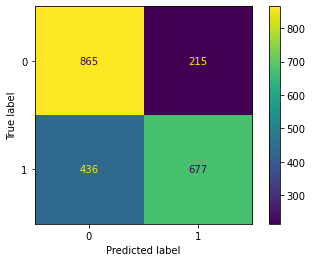

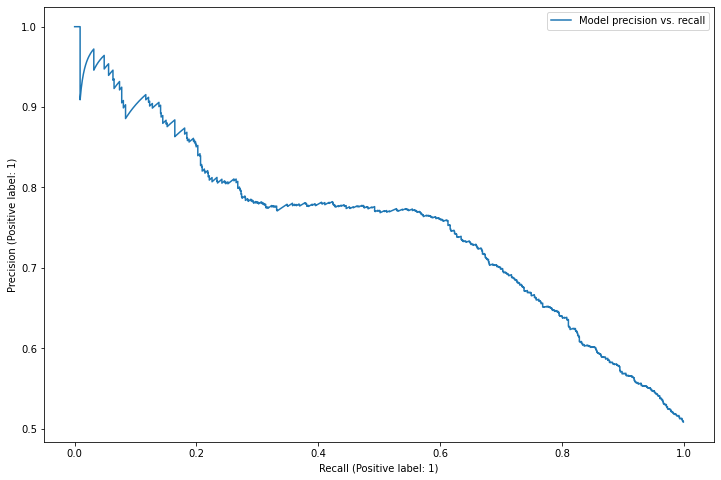

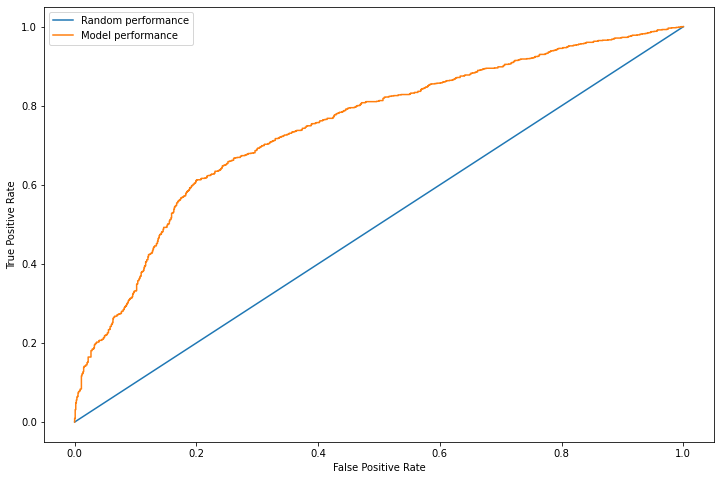

In [18]:
# display results for the best estimator we found
predictions = best_estimator.predict(df_features)
probabilities = best_estimator.predict_proba(df_features)[:,1]
mindwandering.evaluate.evaluate_model_results(mind_wandered_label, predictions, probabilities)

In [19]:
# save the results and preliminary figures in the following cells

# create base save file name for this file, use datetime to keep a unique file name
now = datetime.now()
date_time = now.strftime('%Y%m%d-%H%M')
result_file_basename = 'replication-07-Neural-Network-using-conv1d-GRU-undersampling' + date_time
print(result_file_basename)

replication-07-Neural-Network-using-conv1d-GRU-undersampling20210527-0116


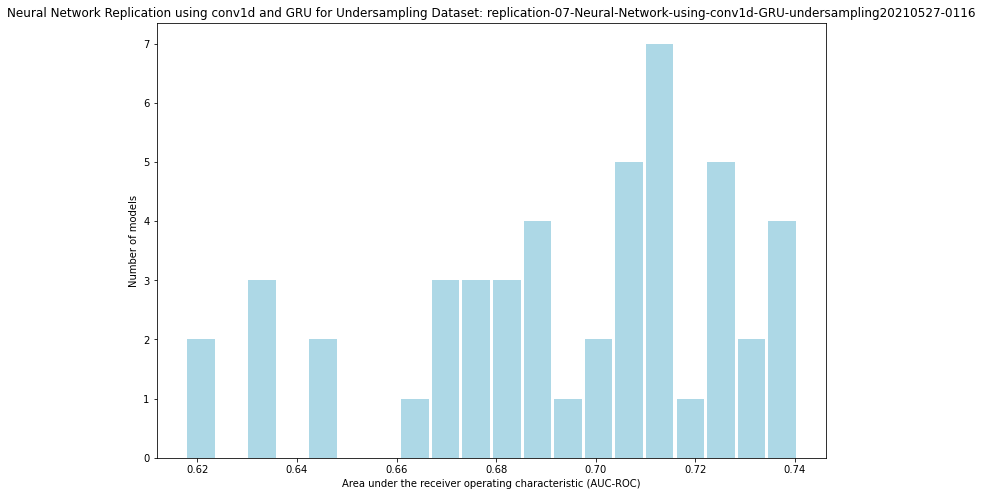

In [20]:
# A quick histogram of this search auc-roc scores.  Basically the figure 1 from the paper.
plt.figure(figsize=(12,8))

#bins = np.linspace(0.605, 0.612, 8)
plt.hist(df_result.mean_test_roc_auc, 
         bins=20,
         color='lightblue',
         rwidth=0.9);
#plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.ylabel('Number of models');
plt.title('Neural Network Replication using conv1d and GRU for Undersampling Dataset: ' + result_file_basename);

result_dir = '../figures'
result_file_name = result_file_basename + '.eps'
result_file_path = os.path.join(result_dir, result_file_name)
plt.savefig(result_file_path)